### Importing libraries and tools

In [97]:
import pandas as pd
import numpy as np

import scipy
from scipy.stats.mstats import winsorize
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, mean_absolute_error, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score

from datetime import datetime
import datetime as dt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Amazon Stock Price Data

## Loading Data

In [98]:
import yfinance as yahoofinance

getamazoninfo = yahoofinance.Ticker('AMZN')
df_amzn = pd.DataFrame(getamazoninfo.history(period='max'))
df_amzn

Open        High         Low       Close  \
Date                                                                        
1997-05-15 00:00:00-04:00    0.121875    0.125000    0.096354    0.097917   
1997-05-16 00:00:00-04:00    0.098438    0.098958    0.085417    0.086458   
1997-05-19 00:00:00-04:00    0.088021    0.088542    0.081250    0.085417   
1997-05-20 00:00:00-04:00    0.086458    0.087500    0.081771    0.081771   
1997-05-21 00:00:00-04:00    0.081771    0.082292    0.068750    0.071354   
...                               ...         ...         ...         ...   
2024-10-15 00:00:00-04:00  187.630005  188.410004  184.580002  187.690002   
2024-10-16 00:00:00-04:00  187.050003  187.779999  185.610001  186.889999   
2024-10-17 00:00:00-04:00  188.220001  188.940002  186.000000  187.529999   
2024-10-18 00:00:00-04:00  187.149994  190.740005  186.279999  188.990005   
2024-10-21 00:00:00-04:00  188.080002  189.020004  186.399994  188.735001   

                               Volume  Dividends  Stock Splits  
Date                                                            
1997-05-15 00:00:00-04:00  1443120000        0.0           0.0  
1997-05-16 00:00:00-04:00   294000000        0.0           0.0  
1997-05-19 00:00:00-04:00   122136000        0.0           0.0  
1997-05-20 00:00:00-04:00   109344000        0.0           0.0  
1997-05-21 00:00:00-04:00   377064000        0.0           0.0  
...                               ...        ...           ...  
2024-10-15 00:00:00-04:00    32178900        0.0           0.0  
2024-10-16 00:00:00-04:00    23456800        0.0           0.0  
2024-10-17 00:00:00-04:00    25039400        0.0           0.0  
2024-10-18 00:00:00-04:00    37379700        0.0           0.0  
2024-10-21 00:00:00-04:00    14253534        0.0           0.0  

[6904 rows x 7 columns]

In [99]:
df_amzn_info = pd.DataFrame(getamazoninfo.info)
amzn_info = df_amzn_info.transpose()
amzn_info[[0]]

0
address1           410 Terry Avenue North
city                              Seattle
state                                  WA
zip                            98109-5210
country                     United States
...                                   ...
grossMargins                      0.48043
ebitdaMargins                     0.17217
operatingMargins                  0.09915
financialCurrency                     USD
trailingPegRatio                    1.629

[119 rows x 1 columns]

In [100]:
print(getamazoninfo.actions)

                           Dividends  Stock Splits
Date                                              
1998-06-02 00:00:00-04:00        0.0           2.0
1999-01-05 00:00:00-05:00        0.0           3.0
1999-09-02 00:00:00-04:00        0.0           2.0
2022-06-06 00:00:00-04:00        0.0          20.0


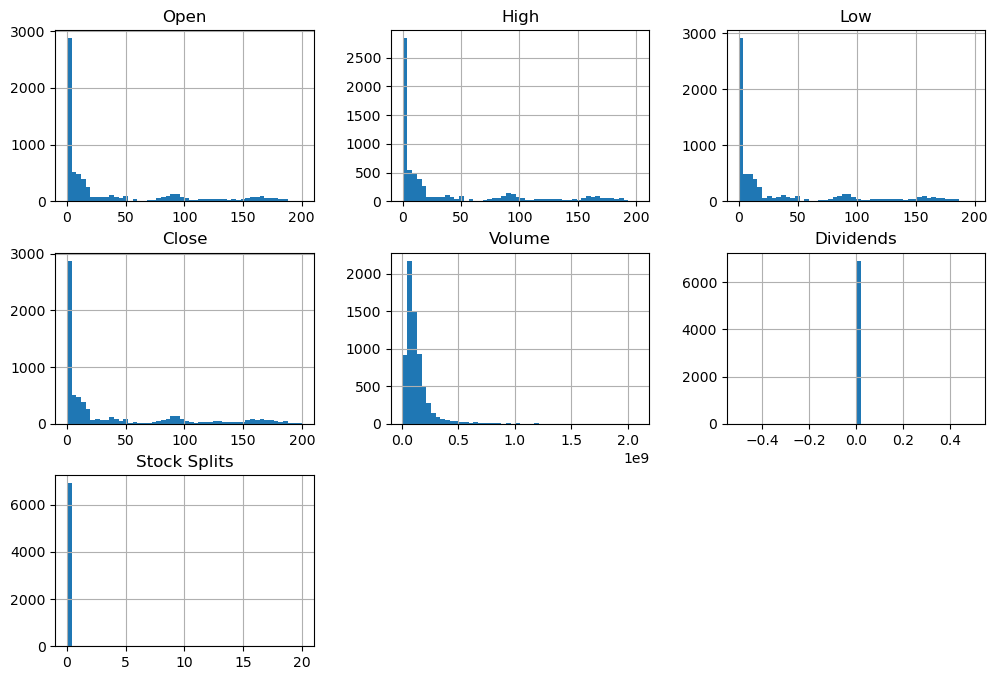

In [101]:
df_amzn.hist(bins=50,figsize=(12,8))
plt.show()

In [102]:
import plotly.graph_objects as go
import plotly.offline as py

# Candlestick chart
candlestick = go.Figure(data=[go.Candlestick(x=df_amzn.index,
                                              open=df_amzn['Open'],
                                              high=df_amzn['High'],
                                              low=df_amzn['Low'],
                                              close=df_amzn['Close'])])

candlestick.update_layout(title= 'Amazon Candlestick Chart',
                          xaxis_title='Date',
                          yaxis_title='Stock Price (USD)',
                          xaxis_rangeslider_visible=False,
                         width=1200, height=600)

candlestick.show()
#py.plot(candlestick, filename='candlestick.html', auto_open=True)

<Figure size 640x480 with 0 Axes>

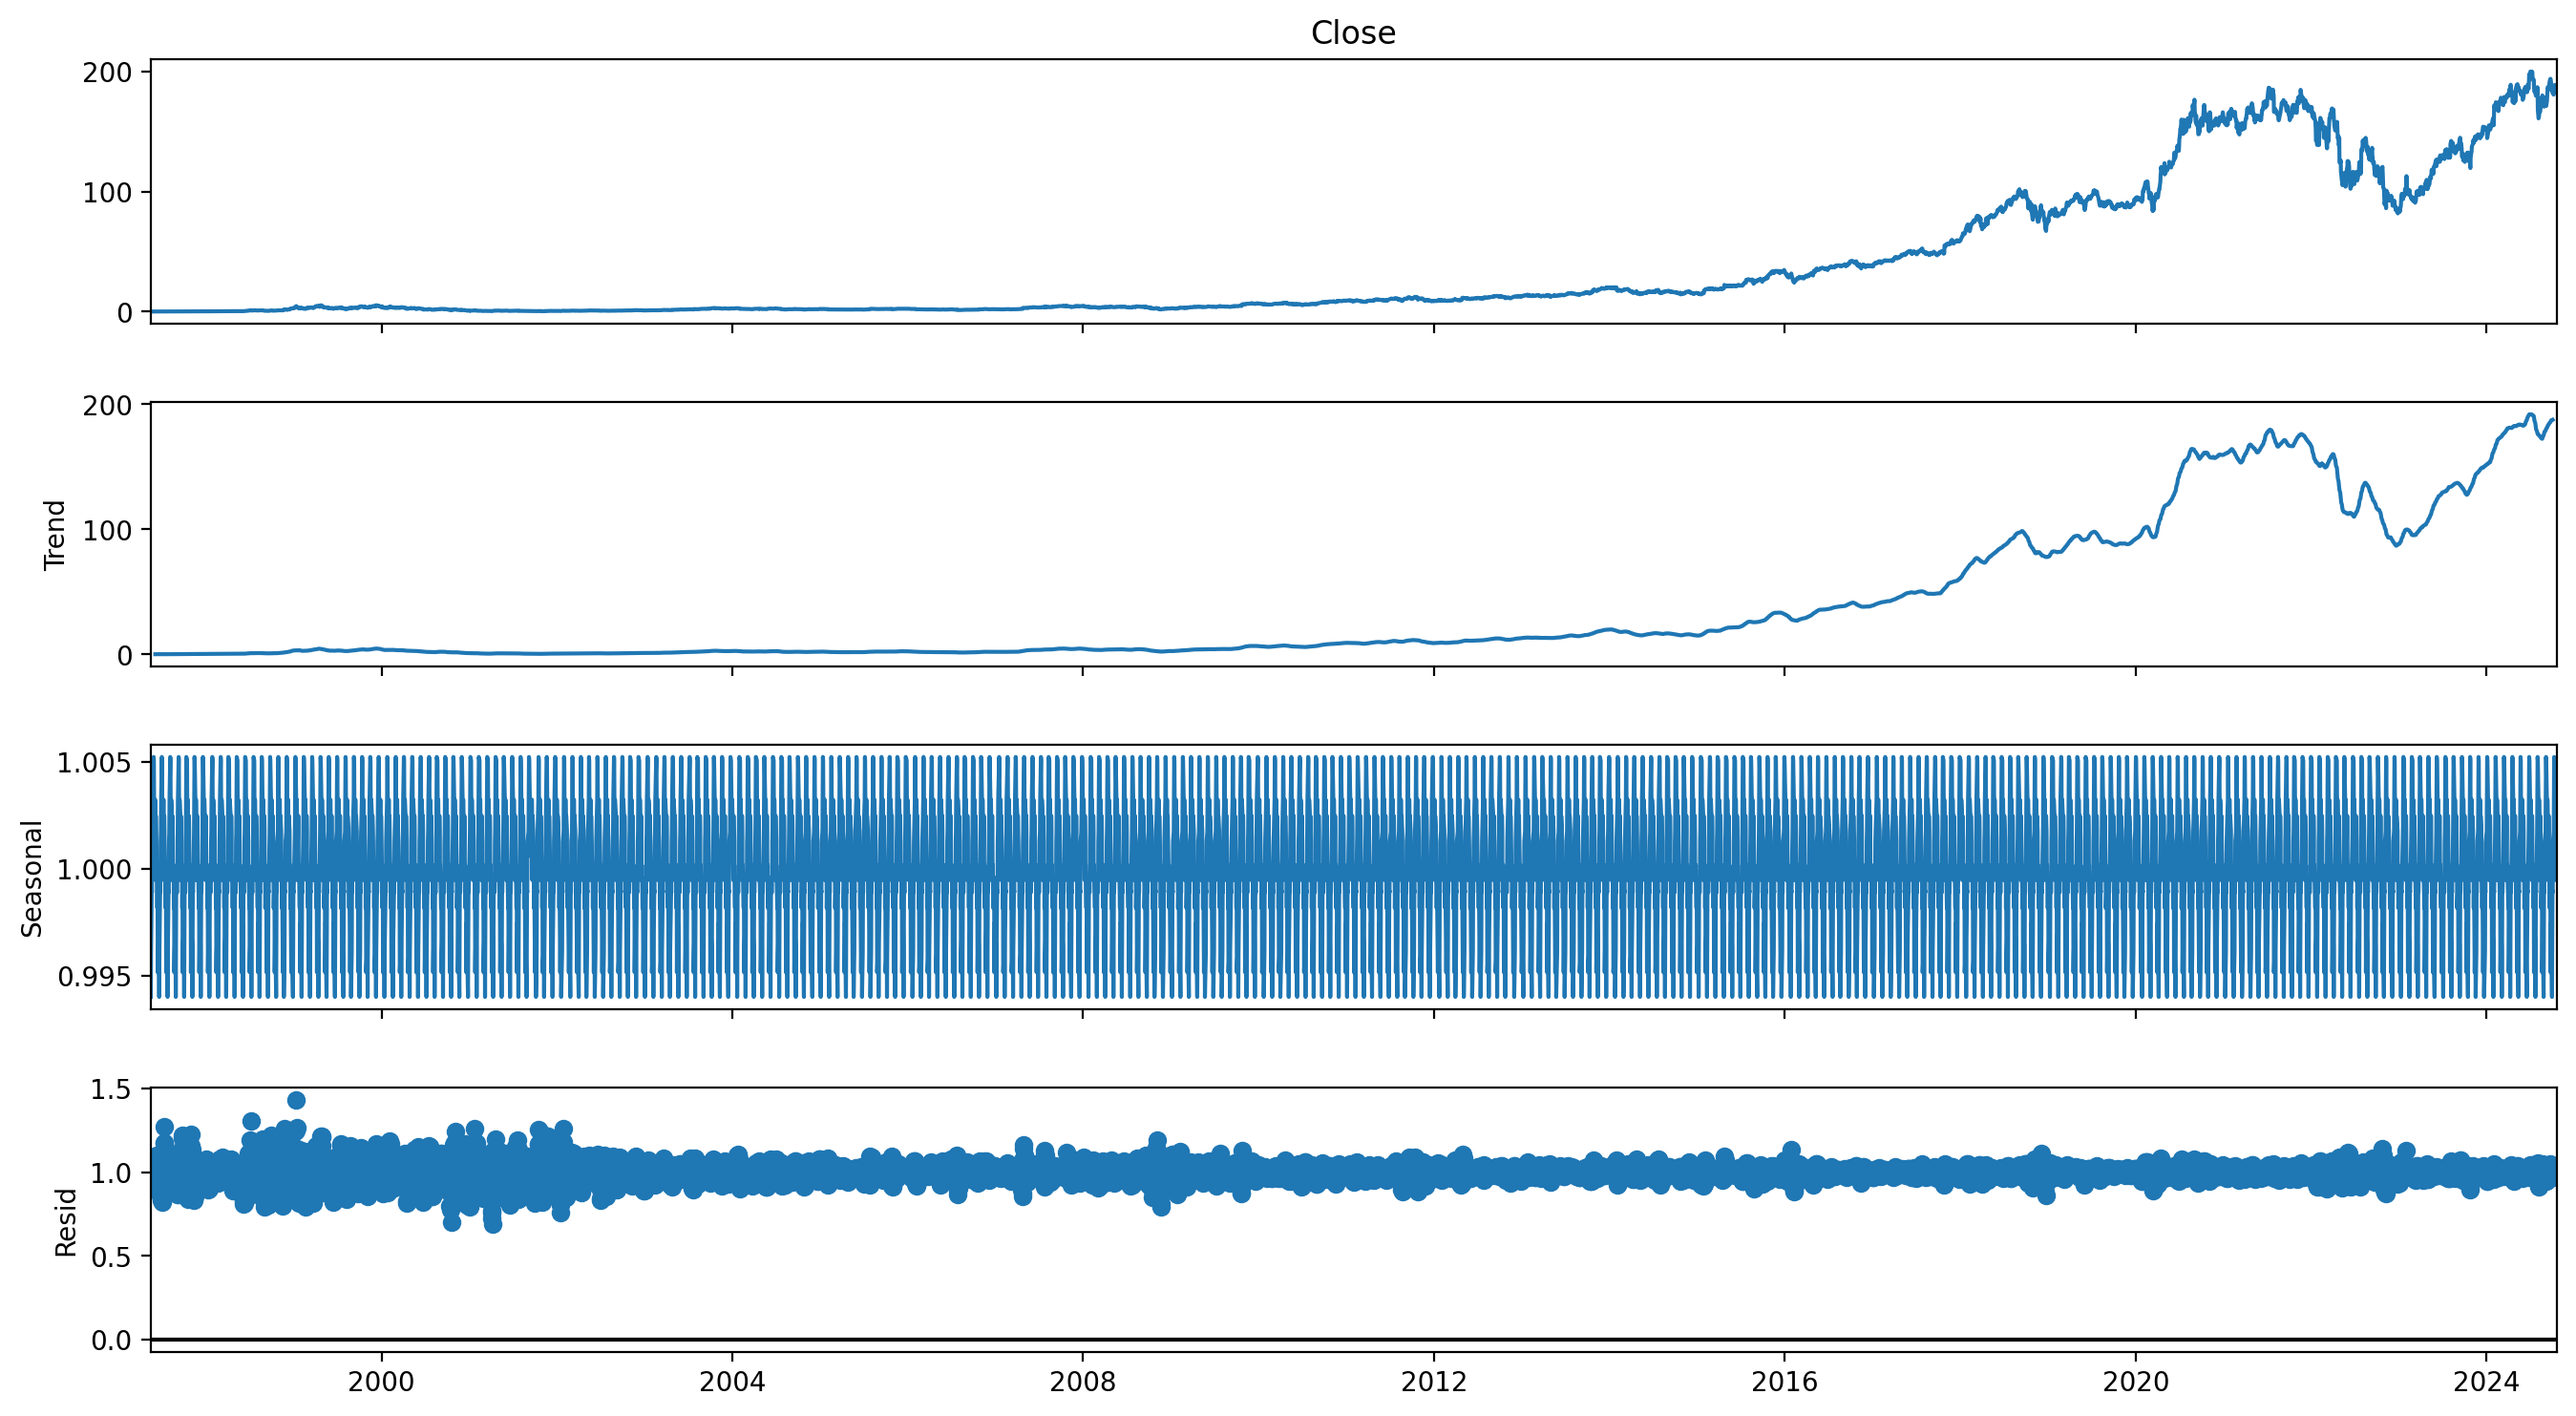

In [103]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_amzn['Close'], model='multiplicative', period=24)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 8)
fig.dpi = 200
fig.show()

## Exploratory Data Analysis

### Missing values and Outliers

In [104]:
df_amzn.isnull().sum()*100/len(df_amzn)

Open            0.0
High            0.0
Low             0.0
Close           0.0
Volume          0.0
Dividends       0.0
Stock Splits    0.0
dtype: float64

In [105]:
df_amzn.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

There is no missing value in the dataset, but that does not mean there is no gap in that data. The following section detects any possible gap.

#### Gap detection function

The following function records gaps in the stock dataset based on a threshold determined by the user. It is normal not to have data for the last three days of each week, as markets are usually closed on weekends. However, gaps of longer periods need further attention. So, an ideal threshold for the gap function would be `min_gap = 4`.

In [106]:
# The stock_gap function detects and records gaps in a stock price dataset. 
# The function has two inputs: df is the stock price dataset retrieved by yfinance.Ticker()
# min_gap is the minimum number of days of missing data considered a gap.

#fill_date = pd.date_range(start=pd.Timestamp(df.index[i-1]), end=pd.Timestamp(df.index[i]), freq='D')

def stock_gap(df, min_gap):
    
    gap_df = pd.DataFrame()
    gap_intervals = 0 # to record the number of gap intervals
    empty_row = pd.DataFrame([[np.nan,np.nan,np.nan,np.nan,
                                     np.nan,np.nan,np.nan]],
                                   columns=df_amzn.columns)
    for i in range(len(df)):
        day_diff = df.index[i]-df.index[i-1]
        
        if  day_diff.days > min_gap:
            df_new_0 = df.loc[df.index == df.index[i-1]]
            df_new_1 = df.loc[df.index == df.index[i]]
            gap_intervals += 1
            gap_df = pd.concat([gap_df,df_new_0])

            # filling the gap days with NaN records
            for j in range(day_diff.days-1): 
                gap_df = pd.concat([gap_df,empty_row])
                #gap_amzn.iloc[index] = fill_date[j]
            
            gap_df = pd.concat([gap_df,df_new_1])
            
    if gap_intervals > 0:
        print('{} gaps were found by the minimum gap days of {}.'.format(gap_intervals,min_gap))
        print('='* 50)
        return gap_df
    else:
        print('{} gaps were found by the minimum gap days of {}.'.format(gap_intervals,min_gap))

For the Amazon stock data, according to the following result, there is no significant gap that needs to be filled.

In [107]:
stock_gap(df_amzn,4)

3 gaps were found by the minimum gap days of 4.


Open     High      Low    Close       Volume  \
2001-09-10 00:00:00-04:00   0.420   0.4325   0.4030   0.4315  116672000.0   
0                             NaN      NaN      NaN      NaN          NaN   
0                             NaN      NaN      NaN      NaN          NaN   
0                             NaN      NaN      NaN      NaN          NaN   
0                             NaN      NaN      NaN      NaN          NaN   
0                             NaN      NaN      NaN      NaN          NaN   
0                             NaN      NaN      NaN      NaN          NaN   
2001-09-17 00:00:00-04:00   0.365   0.4025   0.3525   0.3745  211470000.0   
2006-12-29 00:00:00-05:00   2.003   2.0125   1.9675   1.9730   83940000.0   
0                             NaN      NaN      NaN      NaN          NaN   
0                             NaN      NaN      NaN      NaN          NaN   
0                             NaN      NaN      NaN      NaN          NaN   
0                             NaN      NaN      NaN      NaN          NaN   
2007-01-03 00:00:00-05:00   1.934   1.9530   1.9025   1.9350  248102000.0   
2012-10-26 00:00:00-04:00  11.430  11.9355  11.3345  11.9120  227350000.0   
0                             NaN      NaN      NaN      NaN          NaN   
0                             NaN      NaN      NaN      NaN          NaN   
0                             NaN      NaN      NaN      NaN          NaN   
0                             NaN      NaN      NaN      NaN          NaN   
2012-10-31 00:00:00-04:00  11.816  11.9350  11.5250  11.6445   95952000.0   

                           Dividends  Stock Splits  
2001-09-10 00:00:00-04:00        0.0           0.0  
0                                NaN           NaN  
0                                NaN           NaN  
0                                NaN           NaN  
0                                NaN           NaN  
0                                NaN           NaN  
0                                NaN           NaN  
2001-09-17 00:00:00-04:00        0.0           0.0  
2006-12-29 00:00:00-05:00        0.0           0.0  
0                                NaN           NaN  
0                                NaN           NaN  
0                                NaN           NaN  
0                                NaN           NaN  
2007-01-03 00:00:00-05:00        0.0           0.0  
2012-10-26 00:00:00-04:00        0.0           0.0  
0                                NaN           NaN  
0                                NaN           NaN  
0                                NaN           NaN  
0                                NaN           NaN  
2012-10-31 00:00:00-04:00        0.0           0.0

Now, we should determine if there are outliers in the data. It seems that `Volume` behaves differently regarding outliers, so we need a separate plot for that. `Dividends` does has no data that needs to be dealt with.

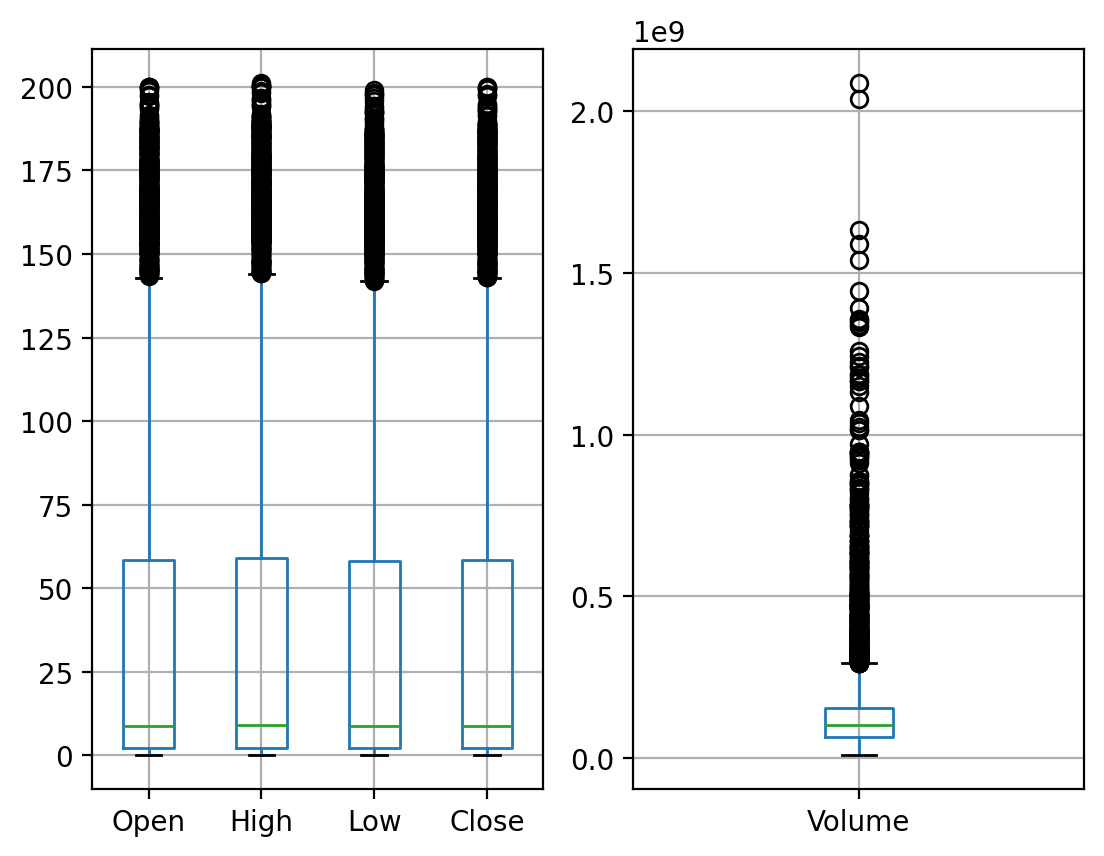

In [108]:
plt.figure(dpi=200)
plt.subplot(1,2,1)
df_amzn[['Open','High','Low','Close']].boxplot()

plt.subplot(1,2,2)
df_amzn[['Volume']].boxplot()

plt.show()

#### Tukey's method

In [109]:
q75, q25 = np.percentile(df_amzn['Volume'], [75 ,25])
iqr = q75 - q25
log_df = pd.DataFrame({'Threshold':[],'Outliers':[]})
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    outliers = len(np.where((df_amzn['Volume'] > max_val)
                      | (df_amzn['Volume'] < min_val))[0])
    
    log_df.loc[len(log_df)] = [threshold,outliers]
log_df

Threshold  Outliers
0        1.0     669.0
1        1.5     473.0
2        2.0     365.0
3        2.5     296.0
4        3.0     240.0
5        3.5     189.0
6        4.0     155.0
7        4.5     135.0

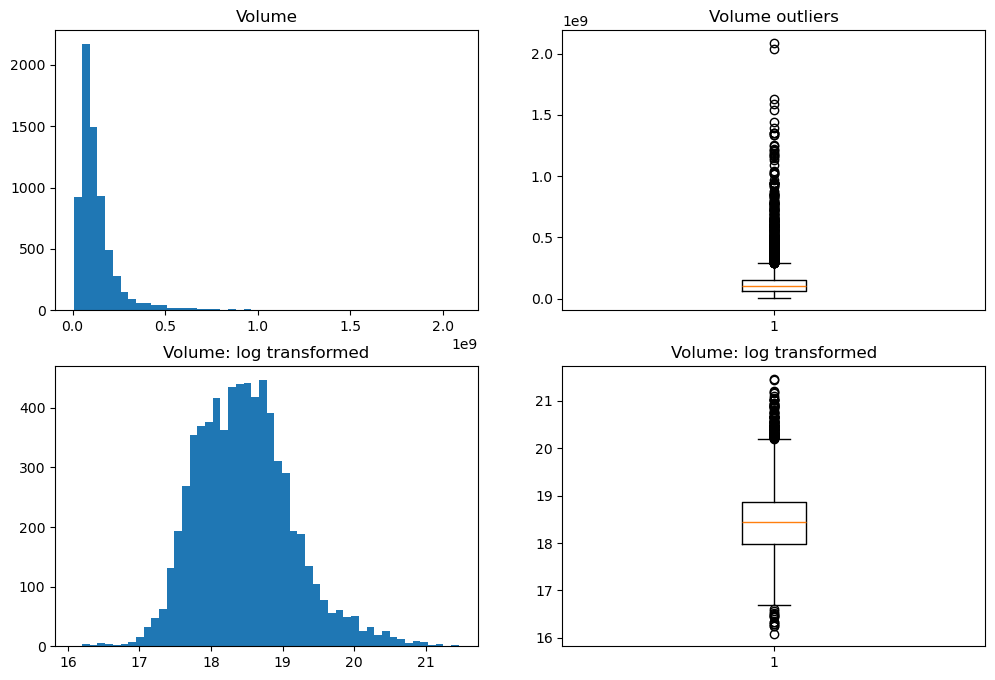

In [110]:
volume_log = np.log(df_amzn['Volume'])

plt.figure(figsize=(12,8), dpi=100)

plt.subplot(2,2,1)
plt.hist(df_amzn['Volume'],bins=50)
plt.title('Volume')

plt.subplot(2,2,2)
plt.boxplot(df_amzn['Volume'])
plt.title('Volume outliers')

plt.subplot(2,2,3)
plt.hist(volume_log,bins=50)
plt.title('Volume: log transformed')

plt.subplot(2,2,4)
plt.boxplot(volume_log)
plt.title('Volume: log transformed')

plt.show()

The charts on the second row demonstrate that log transformation has narrowed the range of values. The outliers that lie beyond the whiskers are now different than the ones on the left chart.

When we apply Tukey's method we see that the number of outliers has decreased:

In [111]:
volume_log = np.log(df_amzn['Volume'])

q75, q25 = np.percentile(volume_log, [75 ,25])
iqr = q75 - q25
log_df = pd.DataFrame({'Threshold':[],'Outliers':[]})
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    outliers = len(np.where((volume_log > max_val)
                      | (volume_log < min_val))[0])
    
    log_df.loc[len(log_df)] = [threshold,outliers]
log_df

Threshold  Outliers
0        1.0     361.0
1        1.5     139.0
2        2.0      41.0
3        2.5       5.0
4        3.0       0.0
5        3.5       0.0
6        4.0       0.0
7        4.5       0.0

We should do the same test and transformation on `Close`.

In [112]:
q75, q25 = np.percentile(df_amzn['Close'], [75 ,25])
iqr = q75 - q25
log_df = pd.DataFrame({'Threshold':[],'Outliers':[]})
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    outliers = len(np.where((df_amzn['Close'] > max_val)
                      | (df_amzn['Close'] < min_val))[0])
    
    log_df.loc[len(log_df)] = [threshold,outliers]
log_df

Threshold  Outliers
0        1.0     951.0
1        1.5     691.0
2        2.0     243.0
3        2.5       3.0
4        3.0       0.0
5        3.5       0.0
6        4.0       0.0
7        4.5       0.0

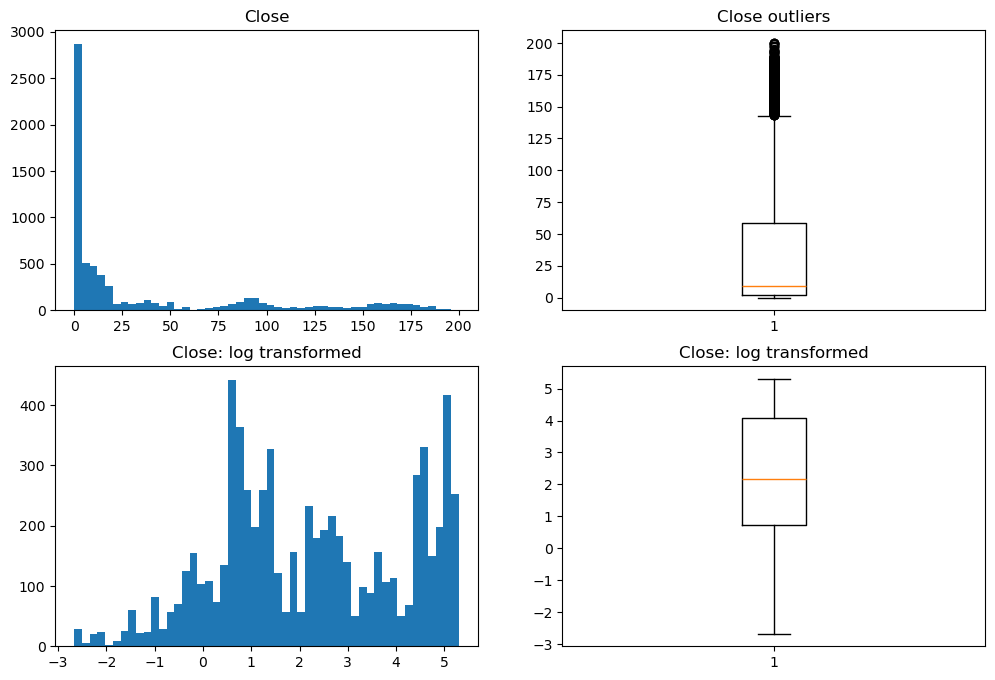

In [113]:
close_log = np.log(df_amzn['Close'])

plt.figure(figsize=(12,8), dpi=100)

plt.subplot(2,2,1)
plt.hist(df_amzn['Close'],bins=50)
plt.title('Close')

plt.subplot(2,2,2)
plt.boxplot(df_amzn['Close'])
plt.title('Close outliers')

plt.subplot(2,2,3)
plt.hist(close_log,bins=50)
plt.title('Close: log transformed')

plt.subplot(2,2,4)
plt.boxplot(close_log)
plt.title('Close: log transformed')

plt.show()

In [114]:
q75, q25 = np.percentile(close_log, [75 ,25])
iqr = q75 - q25
log_df = pd.DataFrame({'Threshold':[],'Outliers':[]})
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    outliers = len(np.where((close_log > max_val)
                      | (close_log < min_val))[0])
    
    log_df.loc[len(log_df)] = [threshold,outliers]
log_df

Threshold  Outliers
0        1.0       5.0
1        1.5       0.0
2        2.0       0.0
3        2.5       0.0
4        3.0       0.0
5        3.5       0.0
6        4.0       0.0
7        4.5       0.0

We will do the log transform for the rest of the features. In evaluating the model, however, we will use both the original and the log-transformed features for comparison.

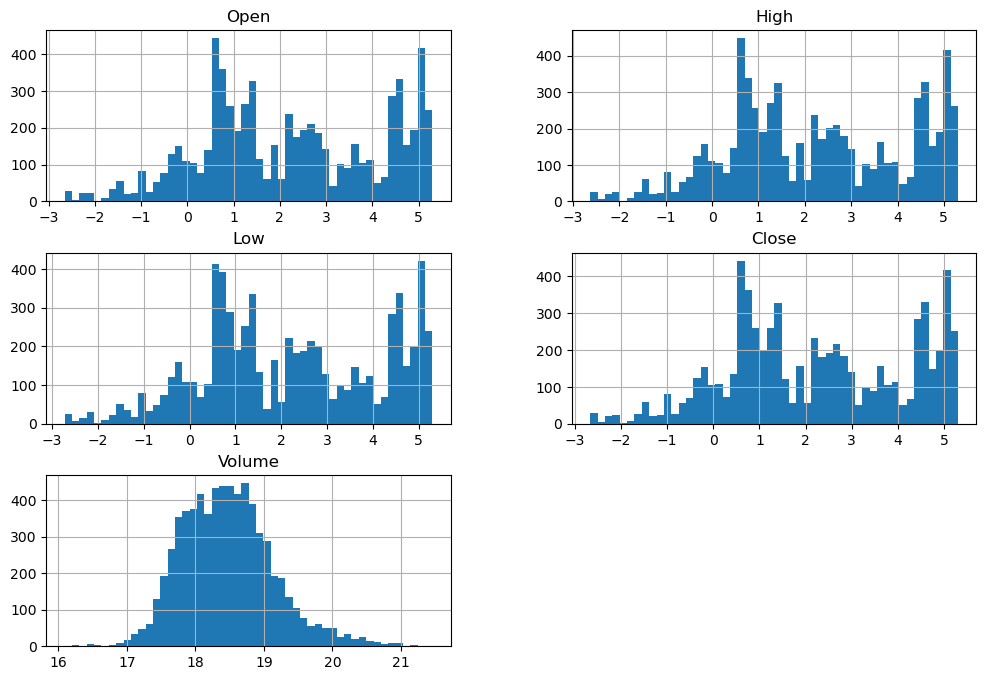

In [115]:
amzn_log = df_amzn.copy()

amzn_log['Open'] = np.log(df_amzn['Open'])
amzn_log['High'] = np.log(df_amzn['High'])
amzn_log['Low'] = np.log(df_amzn['Low'])
amzn_log['Close'] = np.log(df_amzn['Close'])
amzn_log['Volume'] = np.log(df_amzn['Volume'])

amzn_log[['Open','High','Low','Close','Volume']].hist(bins=50, figsize=(12,8))
plt.show()

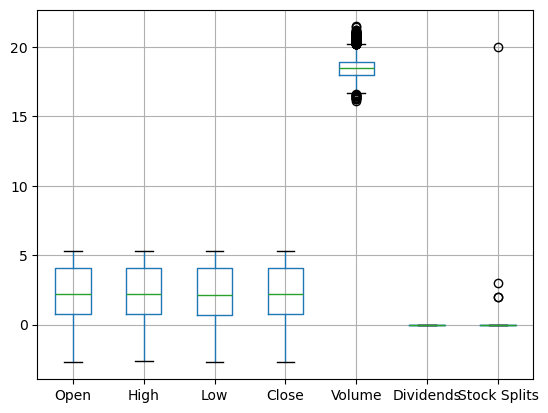

In [116]:
amzn_log.boxplot()
plt.show()

In [117]:
# To see whether there is NaN value after log-transformation
amzn_log.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

### Feature Engineering and Feature Selection

The feature which represents the stock price is `Close`, the number the stock was closed at on a specific day. There might be a correlation between closing prices and trading volume. For example, high volume can be associated with significant price movements, either up or down. Also, high trading volumes can indicate volatility, where closing prices might change dramatically. Volume can reflect market sentiment. High volume during a price increase might indicate strong investor confidence, while high volume during a price decrease might suggest panic selling. Other features, according to the following heatmap, show a high correlation with `Close`. We will add another feature, the daily difference between Open and Close prices as `Open-Close` to see if it has any effect on the closing price.

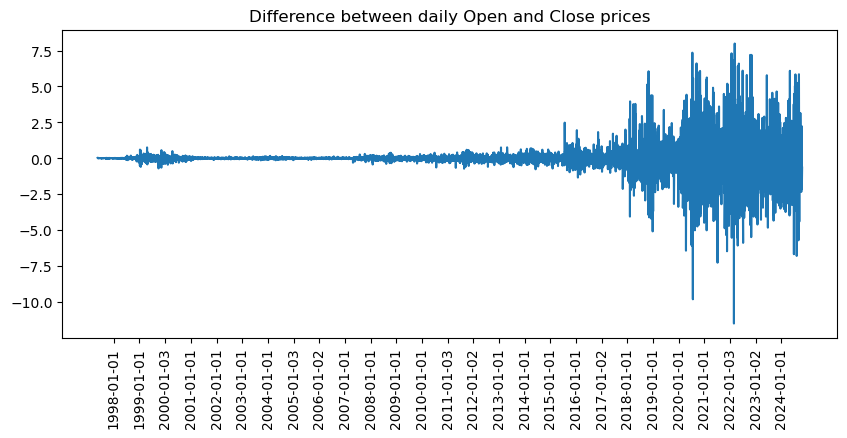

In [118]:
open_close = df_amzn['Open'] - df_amzn['Close']
x_labels = pd.date_range(start=pd.Timestamp(df_amzn.index[0]),
                            end=pd.Timestamp(df_amzn.index[len(df_amzn)-1]), freq='BYS')


plt.figure(figsize=(10,4))
plt.plot(open_close)
plt.title('Difference between daily Open and Close prices')
plt.xticks(x_labels, rotation=90)
plt.show()

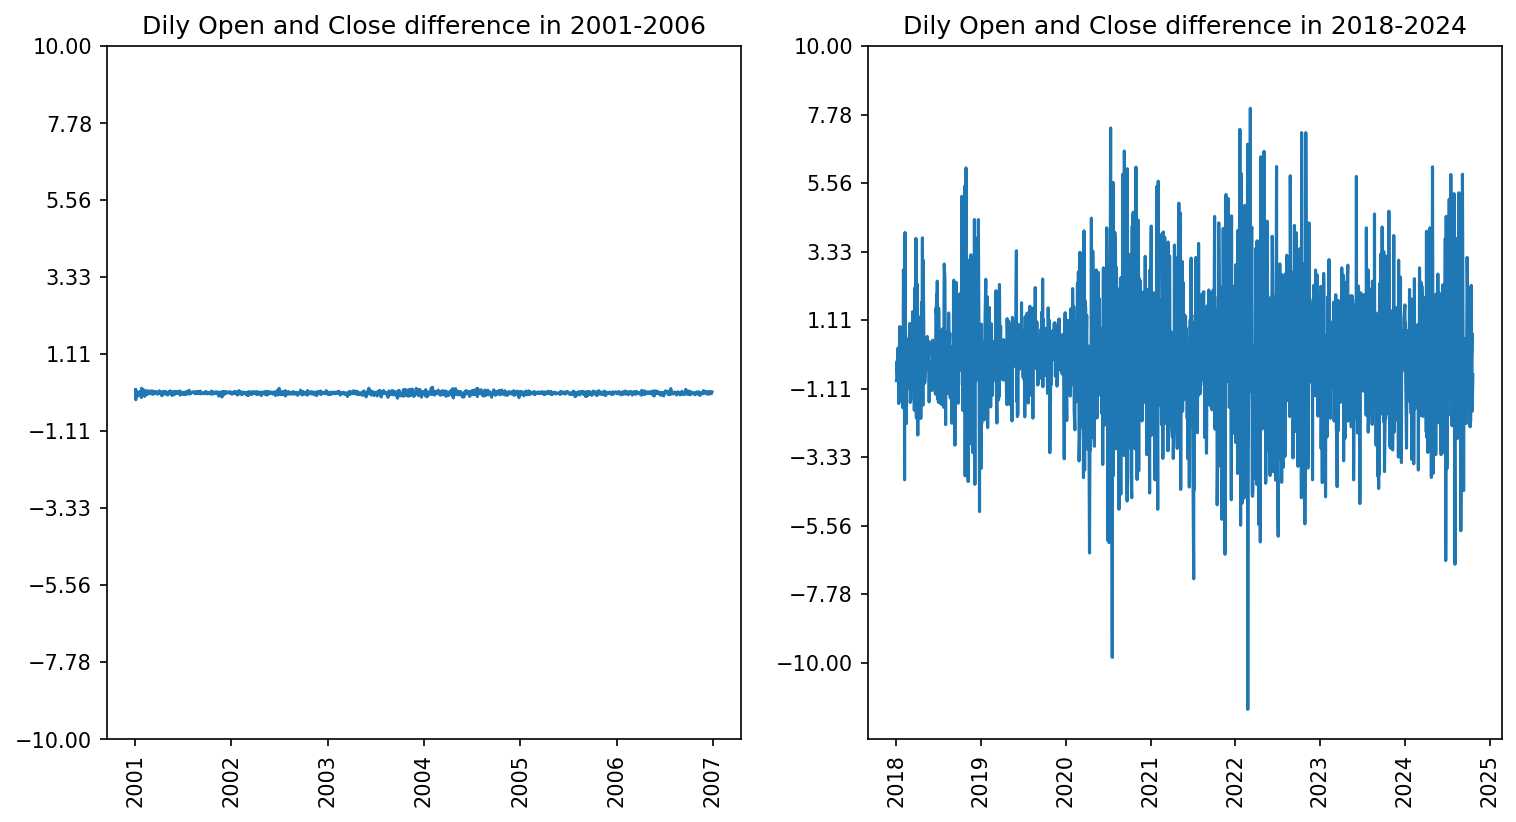

In [119]:
open_close_2005 = df_amzn['Open'][df_amzn.index.year.isin(range(2001,2007))] - df_amzn['Close'][df_amzn.index.year.isin(range(2001,2007))]
open_close_2022 = df_amzn['Open'][df_amzn.index.year.isin(range(2018,2025))] - df_amzn['Close'][df_amzn.index.year.isin(range(2018,2025))]

plt.figure(figsize=(12,6),dpi=150)

plt.subplot(1,2,1)
plt.plot(open_close_2005)
plt.title('Dily Open and Close difference in 2001-2006')
plt.yticks(np.linspace(-10,10,10))
plt.xticks(rotation=90)

plt.subplot(1,2,2)
plt.plot(open_close_2022)
plt.title('Dily Open and Close difference in 2018-2024')
plt.yticks(np.linspace(-10,10,10))
plt.xticks(rotation=90)

plt.show()

In [120]:
amzn_log.drop(['Dividends','Stock Splits'], axis=1, inplace=True)

In [121]:
open_close = df_amzn['Open'] - df_amzn['Close']

# adding Open-Close feature as the difference between the two features
amzn_log['Open-Close'] = np.log(open_close)

# checking for NaN after log-transformation
amzn_log.isna().sum()


Open             0
High             0
Low              0
Close            0
Volume           0
Open-Close    3453
dtype: int64

In [122]:
amzn_log['Open-Close'].sum()

-inf

In [123]:
# Filling NaN values 0
amzn_log['Open-Close'] = amzn_log['Open-Close'].fillna(0)

# replacing -inf with 0
from numpy import inf
amzn_log['Open-Close'][amzn_log['Open-Close'] == -inf] = 0

In [124]:
amzn_log['Open-Close'].sum()

-7898.636191038614

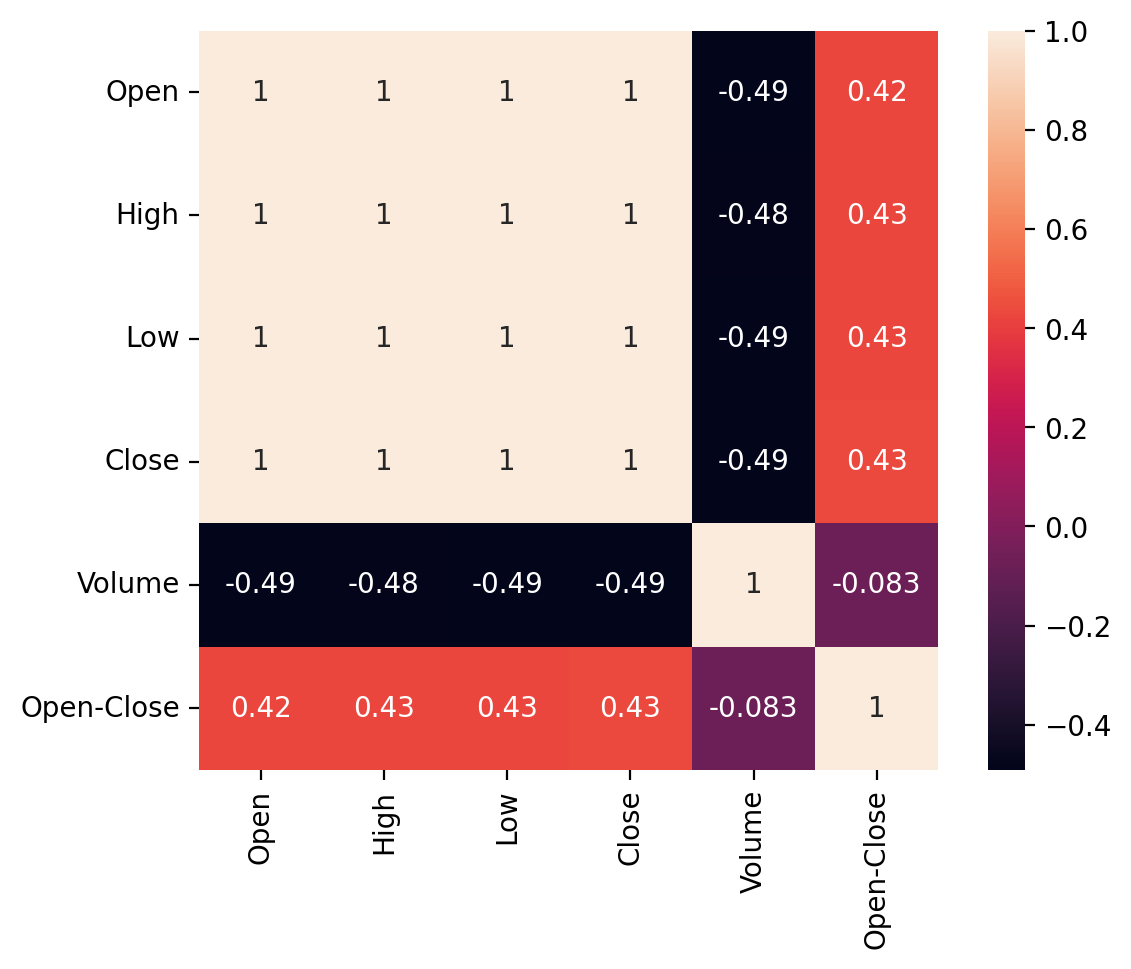

In [125]:
plt.figure(dpi=200)
sns.heatmap(amzn_log.corr(), square=True, annot=True)
plt.show()

## Supervised Learning Models

#### Linear Regression

In [126]:
X = amzn_log[['Open','High','Low','Volume','Open-Close']]
Y = amzn_log['Close']

print(X.shape)
print(Y.shape)

(6904, 5)
(6904,)


In [127]:
lrm = linear_model.LinearRegression()
lrm.fit(X,Y)

y_pred_lrm = lrm.predict(X)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-5.36221204e-01  7.75394044e-01  7.60207958e-01 -1.23709084e-04
  1.51367762e-03]

Intercept: 
 0.005901573174215802


In [128]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.262e+07
Date:                Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:05:54   Log-Likelihood:                 20479.
No. Observations:                6904   AIC:                        -4.095e+04
Df Residuals:                    6898   BIC:                        -4.091e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.005      1.086      0.277      -0.005       0.017
Open          -0.5362      0.010    -56.221      0.000      -0.555      -0.518
High           0.7754      0.008     94.719      0.000       0.759       0.791
Low            0.7602      0.008     96.187      0.000       0.745       0.776
Volume        -0.0001      0.000     -0.418      0.676      -0.001       0.000
Open-Close     0.0015      0.000     14.935      0.000       0.001       0.002
==============================================================================
Omnibus:                     1195.403   Durbin-Watson:                   2.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24685.897
Skew:                          -0.183   Prob(JB):                         0.00
Kurtosis:                      12.256   Cond. No.                     1.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

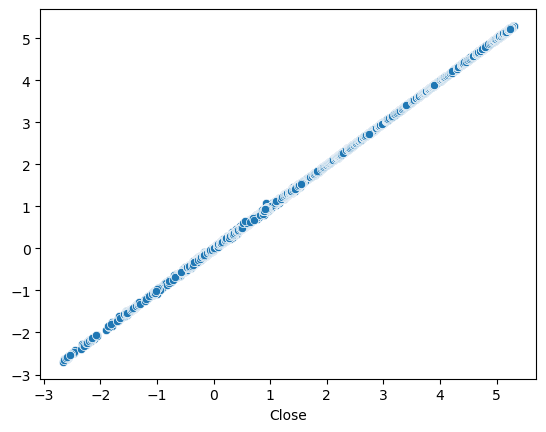

In [129]:
sns.scatterplot(x=Y, y=y_pred_lrm)
plt.show()

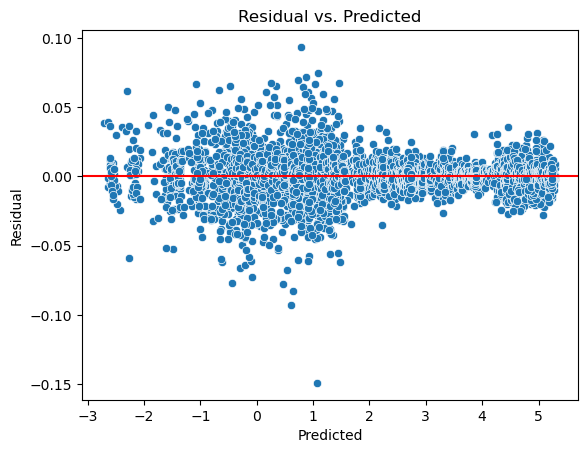

In [130]:
errors = Y-y_pred_lrm
sns.scatterplot(x= y_pred_lrm, y=errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0, c='r')
plt.title('Residual vs. Predicted')
plt.show()

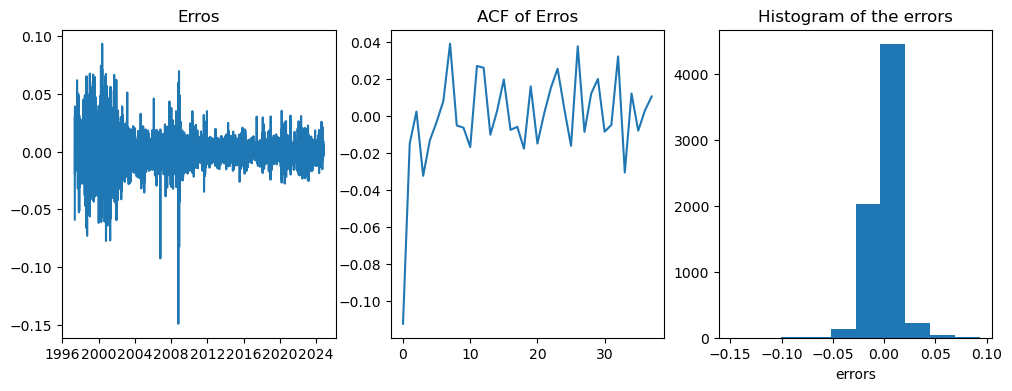

In [131]:
from statsmodels.tsa.stattools import acf
acf_data = acf(errors)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(errors)
plt.title('Erros')

plt.subplot(1,3,2)
plt.plot(acf_data[1:])
plt.title('ACF of Erros')

plt.subplot(1,3,3)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.show()

In [132]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(y_pred_lrm, errors)
lev_stats = levene(y_pred_lrm, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 59945.5 and p value is 0
Levene test statistic value is 19047.8 and p value is 0


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis, which means that the errors are heteroscedastic.

In [133]:
from scipy.stats import jarque_bera, normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print('Jarque-Bera test statstics is {0} and p-value is {1}'.format(jb_stats[0], jb_stats[1]))
print('Normality test statstics is {0} and p-value is {1}'.format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statstics is 24685.897295192714 and p-value is 0.0
Normality test statstics is 1195.4034162399028 and p-value is 2.6390422269223765e-260


The p-values of both tests are lower than 0.05. So, the errors are not normally distributed.

#### OLS model with train and test sets

In [134]:
X_train_ols, X_test_ols, y_train_ols, y_test_ols = train_test_split(X, Y, test_size = 0.2, random_state = 465, shuffle = False)
print(X_train_ols.shape)
print(X_test_ols.shape)

(5523, 6)
(1381, 6)


In [135]:
X_train_ols = sm.add_constant(X_train_ols)
results_ols = sm.OLS(y_train_ols, X_train_ols).fit()
results_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.461e+07
Date:                Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:05:55   Log-Likelihood:                 15997.
No. Observations:                5523   AIC:                        -3.198e+04
Df Residuals:                    5517   BIC:                        -3.194e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.006      1.478      0.140      -0.003       0.021
Open          -0.5161      0.011    -47.994      0.000      -0.537      -0.495
High           0.7682      0.009     82.749      0.000       0.750       0.786
Low            0.7472      0.009     83.175      0.000       0.730       0.765
Volume        -0.0003      0.000     -0.828      0.408      -0.001       0.000
Open-Close     0.0018      0.000     15.923      0.000       0.002       0.002
==============================================================================
Omnibus:                      893.733   Durbin-Watson:                   2.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15424.375
Skew:                          -0.188   Prob(JB):                         0.00
Kurtosis:                      11.178   Cond. No.                     1.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

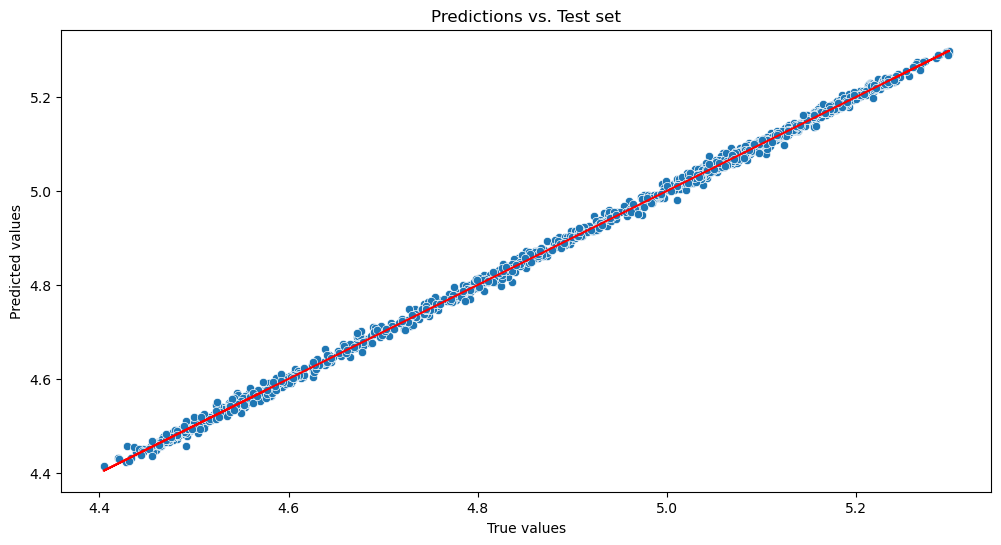

In [136]:
plt.figure(figsize=(12,6))
X_test_ols = sm.add_constant(X_test_ols)
y_preds_ols = results_ols.predict(X_test_ols)
sns.scatterplot(x=y_test_ols, y=y_preds_ols)
plt.plot(y_test_ols,y_test_ols, color='red')
plt.title('Predictions vs. Test set')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

In [137]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test_ols, y_preds_ols)))
print("Mean squared error of the prediction is: {}".format(mse(y_test_ols, y_preds_ols)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test_ols, y_preds_ols)))

Mean absolute error of the prediction is: 0.006026300664132251
Mean squared error of the prediction is: 6.394348622725527e-05
Root mean squared error of the prediction is: 0.007996467109121082


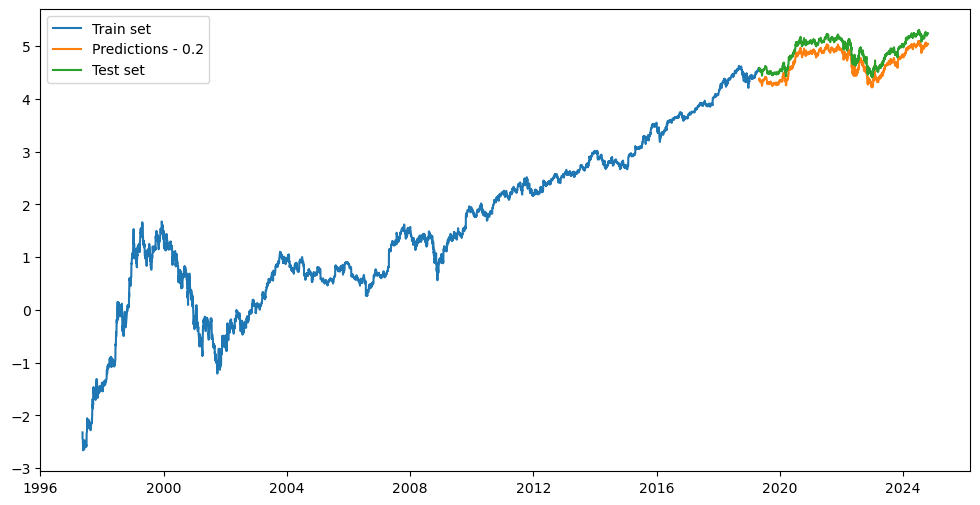

In [138]:
plt.figure(figsize=(12,6))
plt.plot(y_train_ols, label ='Train set')
plt.plot(y_preds_ols - 0.2, label = 'Predictions - 0.2')
plt.plot(y_test_ols, label = 'Test set')
plt.legend()
plt.show()

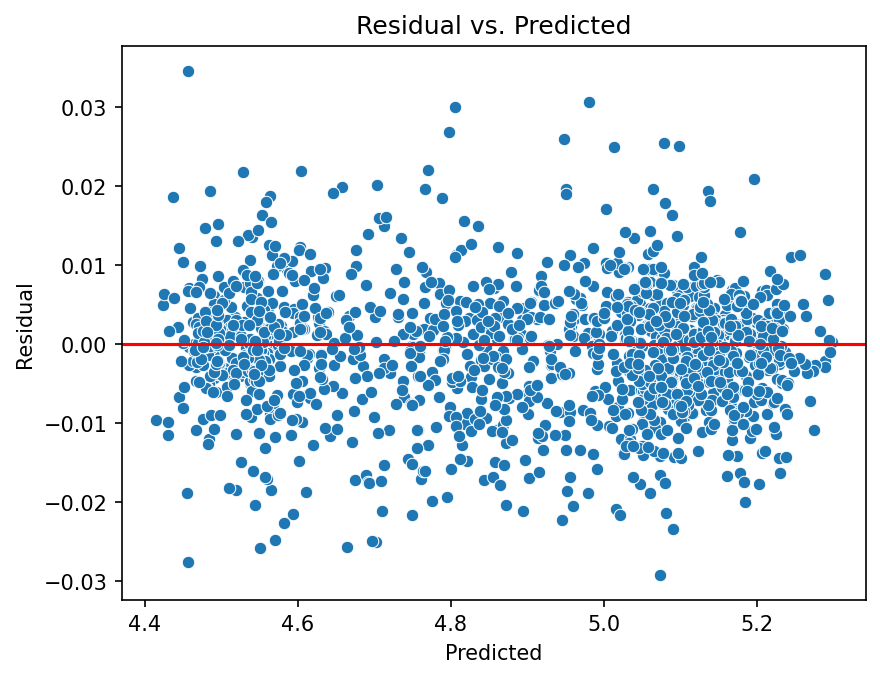

In [139]:
errors_ols = y_test_ols-y_preds_ols

plt.figure(dpi=150)
sns.scatterplot(x= y_preds_ols, y=errors_ols)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0, c='r')
plt.title('Residual vs. Predicted')
plt.show()

#### Random Forest Regressor

Now, we perform a all-features random forest model using 10-fold CV. First, we shoud split the data into train and test sets.

In [140]:
X = amzn_log[['Open','High','Low','Volume','Open-Close']]
Y = amzn_log['Close']


X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2,
                                                    random_state = 456, 
                                                    shuffle=False)

In [141]:
rfr = ensemble.RandomForestRegressor(n_estimators=100, n_jobs=-1)
scores_rfr = cross_val_score(rfr, X, Y, cv=10)
print(scores_rfr)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_rfr.mean(), scores_rfr.std()))

[0.89759521 0.99662504 0.99670988 0.99931773 0.95031178 0.70136111
 0.76868229 0.7523271  0.99915617 0.99549856]
0.91 accuracy with a standard deviation of 0.11


We can get an initial sense of how many of the features are more important by examining the feature importances calculated by scikit-learn during the model-building process

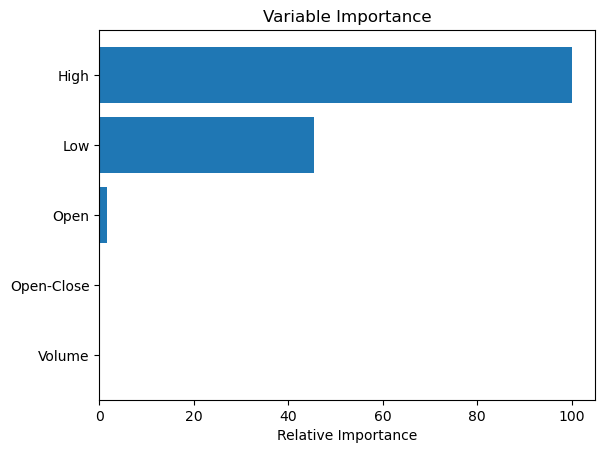

In [142]:
rfr.fit(X,Y)
feature_importance = rfr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [143]:
y_preds_rfr = rfr.predict(X_test)
y_preds_rfr = pd.Series(y_preds_rfr, index = X_test.index)

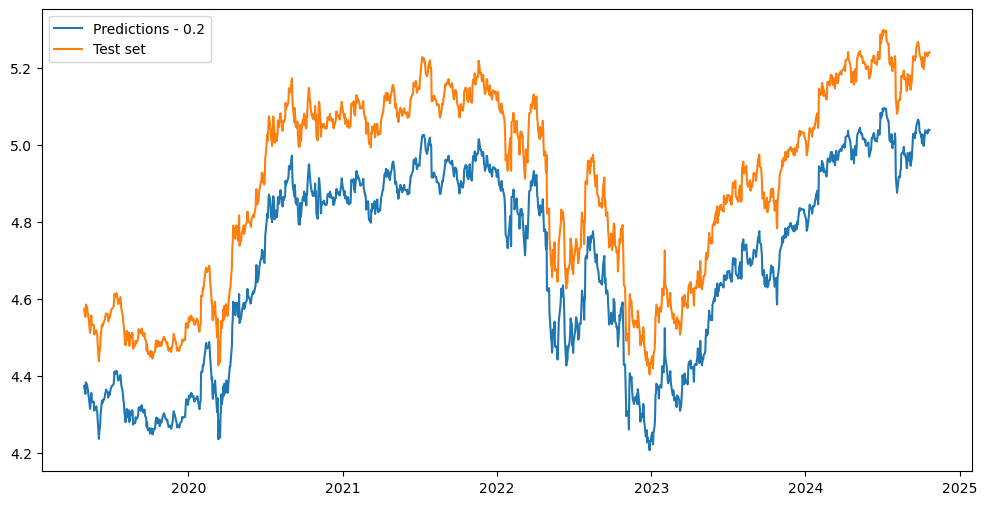

In [144]:
plt.figure(figsize=(12,6))
plt.plot(y_preds_rfr - 0.2, label = 'Predictions - 0.2')
plt.plot(y_test, label = 'Test set')
plt.legend()
plt.show()

#### Gradient Boosting Regressor

In [145]:
gbr = ensemble.GradientBoostingRegressor(loss='squared_error',
                                                 learning_rate=0.1, n_estimators=100)
gbr.fit(X_train, y_train)

gbr_score = gbr.score(X_test,y_test)
gbr_score_train = gbr.score(X_train,y_train)

gbr_prediction = gbr.predict(X_test)

print('Accuracy of test score = {}'.format(gbr_score))
print('Accuracy of train score = {}'.format(gbr_score_train))

Accuracy of test score = -1.3219874175285389
Accuracy of train score = 0.9998972992056736


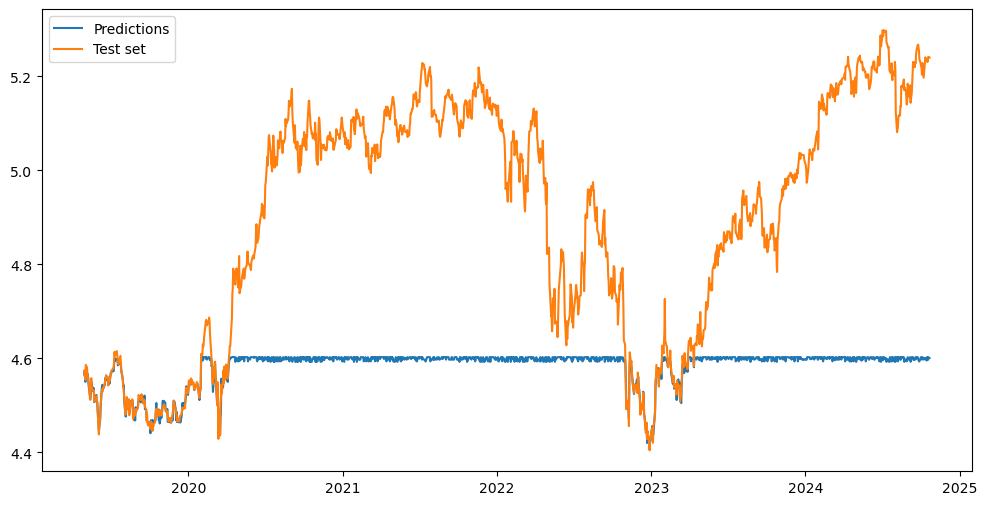

In [146]:
y_preds_gbr = gbr.predict(X_test)
y_preds_gbr = pd.Series(y_preds_gbr, index = X_test.index)


plt.figure(figsize=(12,6))
plt.plot(y_preds_gbr, label = 'Predictions')
plt.plot(y_test, label = 'Test set')
plt.legend()
plt.show()

The `accuracy = 1` on the train set is excellent, but the model did poorly on the test set which may indicate overfitting.

## Deep Learning Models

### MLP Regression

In [147]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [148]:
mlp_reg = MLPRegressor(hidden_layer_sizes=[50,50,50],
                       activation='relu',
                       solver='adam',
                       random_state=42)
#pipeline = make_pipeline(StandardScaler(), mlp_reg)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp_reg.fit(X_train, y_train)
y_pred = mlp_reg.predict(X_test)
mlp_pred = mlp_reg.predict(X_test)

In [149]:
mlp_pred_df = pd.DataFrame(mlp_pred)
mlp_pred_df.set_index(y_test.index, inplace=True)

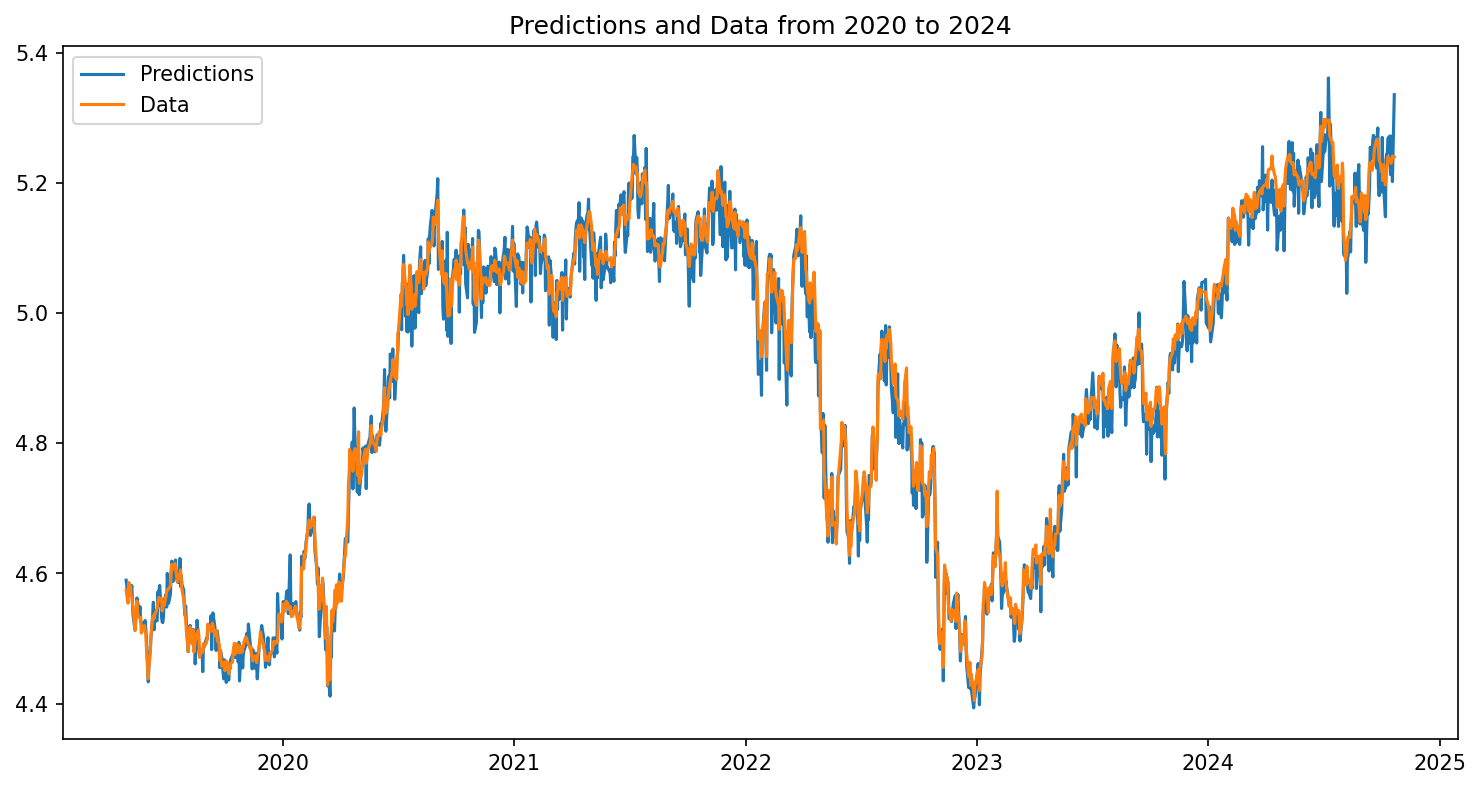

In [150]:
plt.figure(figsize=(12,6),dpi=150)
plt.plot(mlp_pred_df, label='Predictions')
plt.plot(y_test, label='Data')
plt.title('Predictions and Data from 2020 to 2024')
plt.legend()

In [151]:
print("R-squared of the model in training set is: {}".format(mlp_reg.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(mlp_reg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_pred)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_pred)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_pred)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_pred) / y_test)) * 100))

R-squared of the model in training set is: 0.9998357576135044
-----Test set statistics-----
R-squared of the model in test set is: 0.9888948580996446
Mean absolute error of the prediction is: 0.02097442095146104
Mean squared error of the prediction is: 0.0007091928886944752
Root mean squared error of the prediction is: 0.026630675708559766
Mean absolute percentage error of the prediction is: 0.424425610204363


The `R-squared` of both the train and test sets are excellent. 

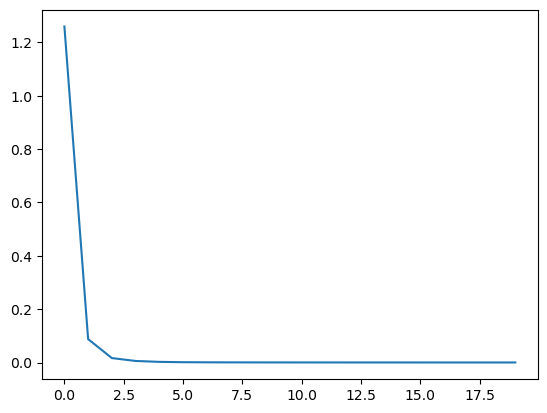

In [152]:
plt.plot(mlp_reg.loss_curve_)
plt.show()

### Time Series Analysis

In [ ]:
plt.plot(df_amzn.index, df_amzn.Close, '--', label='Close')
plt.title('Amazon Stock Closing Price Time Series')
plt.show()

In [ ]:
amzn_diff = df_amzn.copy()
amzn_diff['diff1'] = df_amzn['Close'] - df_amzn['Close'].shift()
amzn_diff.plot(y='diff1')
plt.title('Amazon Stock Closing Price Time Series')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import pacf

x_acf = pd.DataFrame(pacf(amzn_diff['Close']))
x_acf.plot(kind='bar')
plt.title('Amazon AR(1) PACF')
plt.show()

In [ ]:
x_acf = pd.DataFrame(pacf(amzn_diff['diff1'][1:]))
x_acf.plot(kind='bar')
plt.title('Amazon MA(1) PACF')
plt.show()

In [ ]:
amzn_diff['diff1']= amzn_diff[['diff1']].fillna(0)

In [ ]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(df_amzn['Close'])
print(f'ADF Statistic (original data): {result[0]}')
print(f'p-value (original data): {result[1]}')

print() 

result = adfuller(amzn_diff['diff1'])
print(f'ADF Statistic (differencing): {result[0]}')
print(f'p-value (differencing): {result[1]}')

So the data is stationary by differencing.

### ARIMA model

In [153]:
import pmdarima as pm
from pmdarima.arima import auto_arima
model = auto_arima(df_amzn['Close'], seasonal=True, m=52, suppress_warnings=True)
print(model.order)

ModuleNotFoundError: No module named 'pmdarima'

In [154]:
train_data, test_data = train_test_split(df_amzn['Close'], test_size = 0.2,
                                                    random_state = 456, 
                                                    shuffle=False)
print(train_data.shape)
print(test_data.shape)

(5523,)
(1381,)


In [155]:
model_arima_amzn = ARIMA(train_data,
             order=(1,1,1))
model_fit_amzn = model_arima_amzn.fit()

print(model_fit_amzn.summary())
print('-'*60)
print('Residuals Description')
print(model_fit_amzn.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5523
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4007.761
Date:                Mon, 21 Oct 2024   AIC                           8021.522
Time:                        13:06:28   BIC                           8041.372
Sample:                             0   HQIC                          8028.444
                               - 5523                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7773      0.035     22.428      0.000       0.709       0.845
ma.L1         -0.8049      0.033    -24.510      0.000      -0.869      -0.741
sigma2         0.2500      0.001    259.085      0.0

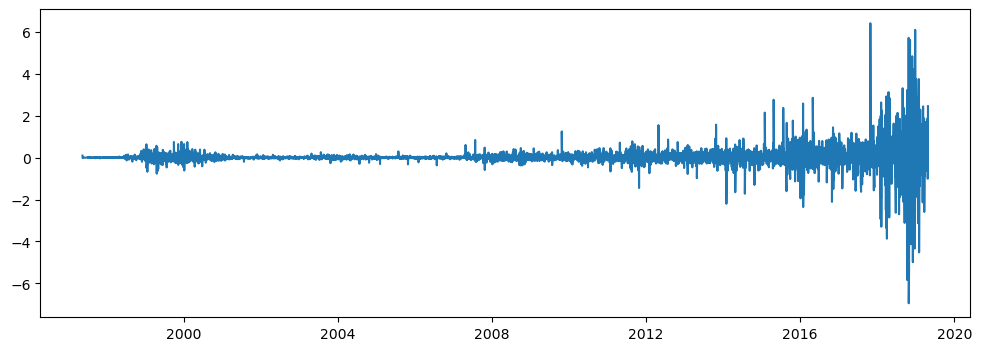

In [156]:
arima_amzn_residuals = model_fit_amzn.resid

plt.figure(figsize=(12,4))
plt.plot(arima_amzn_residuals)
plt.show()

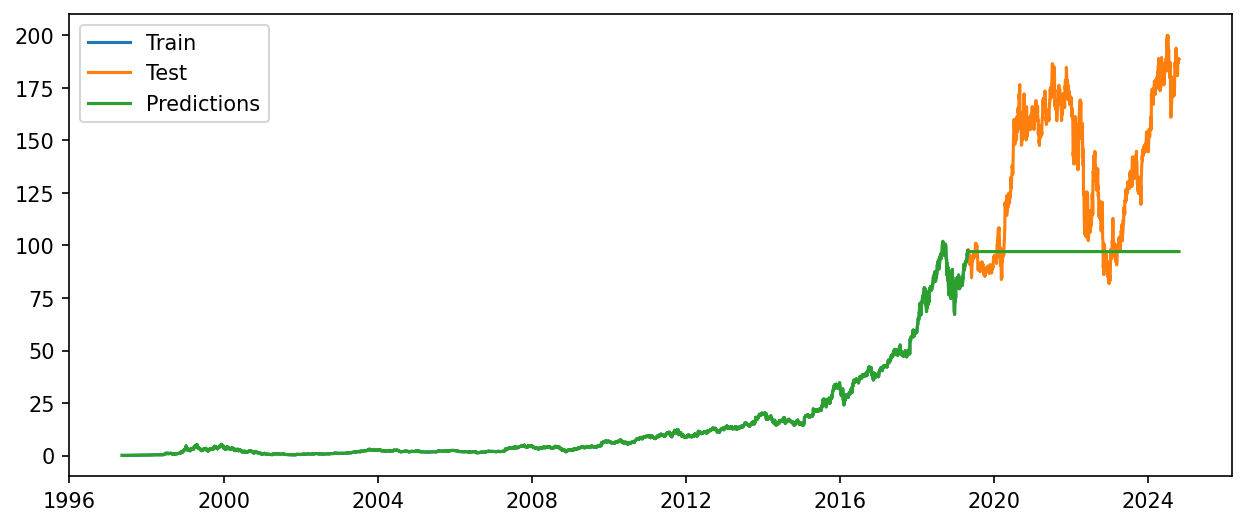

In [158]:
y_pred = model_fit_amzn.forecast(steps=1381)
train_pred = pd.concat([train_data,y_pred], ignore_index=True)
test_pred = pd.DataFrame(train_pred)
test_pred.set_index(df_amzn.index, inplace=True)

plt.figure(figsize=(10,4),dpi=150)
plt.plot(train_data, label="Train")
plt.plot(test_data, label="Test")
plt.plot(test_pred, label='Predictions')
plt.legend()
plt.show()

The `ARIMA` model did poorly on predictions.

Trying the `ARIMA` model in a loop for a specific time period, starting from 2021-01-01 to today.

In [159]:
start_date = pd.Timestamp(df_amzn.index[df_amzn.index.year == 2015][0])
end_date = pd.Timestamp(df_amzn.index[df_amzn.shape[0]-1])
df_slice = df_amzn.loc[start_date:end_date]


y_preds_acc = []

for today in df_slice.index:
    model = ARIMA(df_amzn.loc[start_date:today]['Close'],
                  order=(0,1,0),
                  )
    model = model.fit()
    model_forecast = model.forecast()
    y_preds_acc.append(model_forecast)

In [160]:
forecasts = pd.Series(y_preds_acc, index=df_slice.index)
forecasts = forecasts.astype(float)
forecasts_diff = (forecasts-df_amzn.loc[start_date:end_date]['Close']).abs().mean()
print('The MAE for accumulative forecast for 2019-2024 is: {}'.format(forecasts_diff))

The MAE for accumulative forecast for 2019-2024 is: 2.4016531681005224e-13


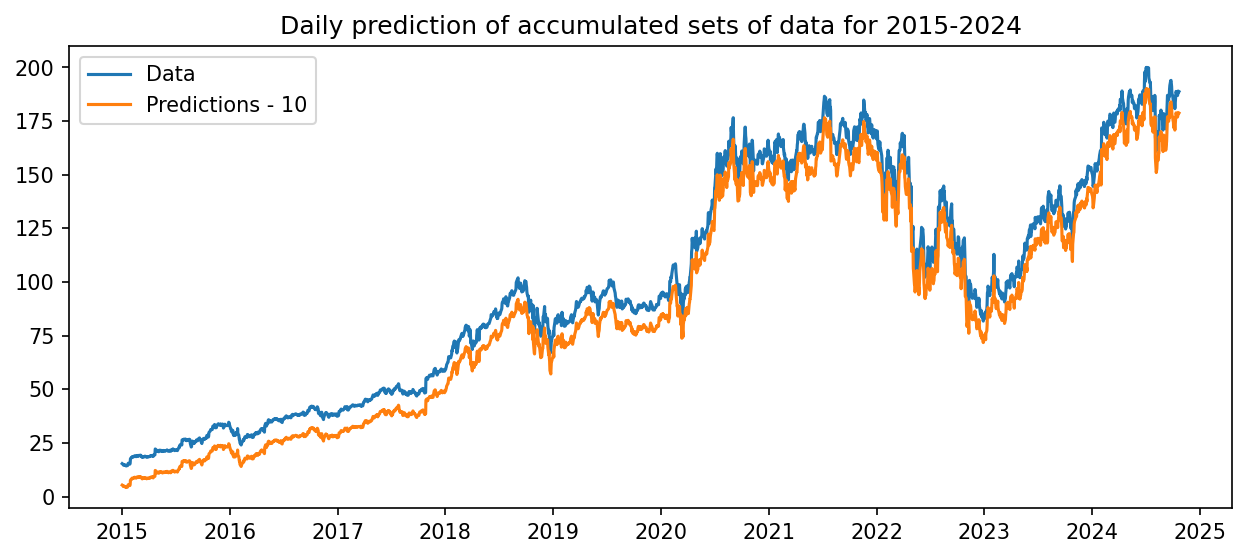

In [161]:
#forecasts = pd.Series(y_preds_acc, index=df_slice.index)

plt.figure(figsize=(10,4),dpi=150)
plt.plot(df_amzn.loc[start_date:end_date]['Close'], label="Data")
plt.plot(forecasts-10, label='Predictions - 10')
plt.title('Daily prediction of accumulated sets of data for 2015-2024')
plt.legend()
plt.show()

It seems that the `ARIMA` model predicts tomorrow's price precisely.

### SARIMA model

In [162]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arma_model_result = ARIMA(train, order=order).fit(disp=0)
            aic = arma_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA=%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA=%s AIC=%.2f' % (best_params, best_aic))
    return best_params

In [118]:
import itertools

p = d = q = range(0, 20)
pdq = list(itertools.product(p, d, q))
best_params_aic = arima_optimizer_aic(train_data, pdq)

Best ARIMA=None AIC=inf


In [120]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(train_data, order=(1,1,1))
sarima_model_fit = model_sarima.fit(disp=False)
print(sarima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5520
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3992.944
Date:                Tue, 15 Oct 2024   AIC                           7991.888
Time:                        22:44:12   BIC                           8011.736
Sample:                             0   HQIC                          7998.809
                               - 5520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7849      0.033     23.614      0.000       0.720       0.850
ma.L1         -0.8122      0.031    -25.805      0.000      -0.874      -0.750
sigma2         0.2488      0.001    259.998      0.0

In [122]:
y_pred_sarima = sarima_model_fit.forecast(steps=1380)
mean_absolute_error(test_data, y_pred_sarima)

43.37687437716854

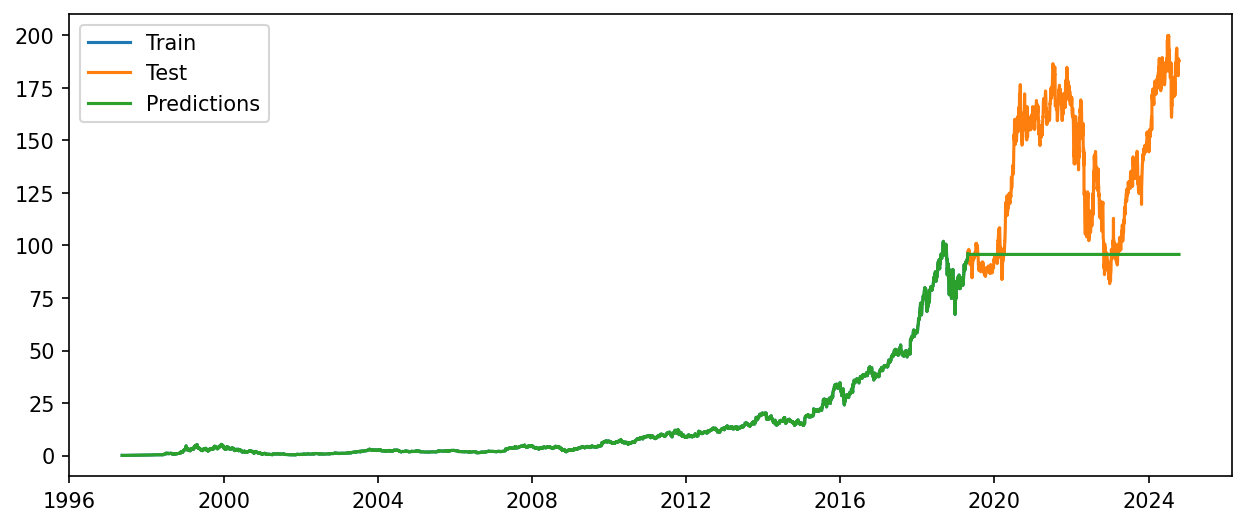

In [124]:
y_pred_sarima = sarima_model_fit.forecast(steps=1380)
train_pred_sarima = pd.concat([train_data,y_pred_sarima], ignore_index=True)
test_pred_sarima = pd.DataFrame(train_pred_sarima)
test_pred_sarima.set_index(df_amzn.index, inplace=True)

plt.figure(figsize=(10,4),dpi=150)
plt.plot(train_data, label="Train")
plt.plot(test_data, label="Test")
plt.plot(test_pred_sarima, label='Predictions')
plt.legend()
plt.show()

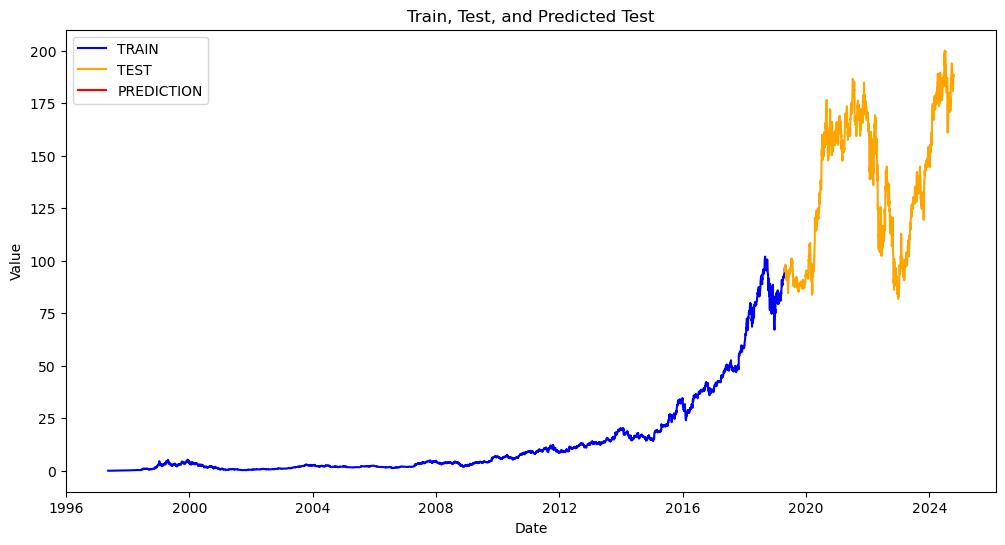

In [126]:
y_pred_sarima_series = pd.Series(y_pred_sarima, index=y_test.index)

# Plot all the series
plt.figure(figsize=(12, 6))

# Plot train data
plt.plot(train_data.index, train_data, label="TRAIN", color='blue')

# Plot test data
plt.plot(test_data.index, test_data, label="TEST", color='orange')

# Plot predictions
plt.plot(y_pred_sarima_series.index, y_pred_sarima_series, label="PREDICTION", color='red')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Train, Test, and Predicted Test')
plt.legend()

plt.show()

### LSTM Model

In [172]:
from sklearn.preprocessing import MinMaxScaler

features = df_amzn[['Open','High','Low','Close','Volume']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

In [173]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

print(train_data.shape)
print(test_data.shape)

(5523, 5)
(1381, 5)


In [201]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        Y.append(data[i + time_step, 3])  # Assuming 'Close' is the fourth column
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(5462, 60, 5)
(1320, 60, 5)
(5462,)


In [175]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

print(X_train.shape)
print(X_test.shape)

(5462, 60, 5)
(1320, 60, 5)


#### Model: `epochs=100`, `batch_size=32`

In [190]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [191]:
model.fit(X_train, y_train, epochs=100, batch_size=32)  

Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0021
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.4384e-04
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.2689e-04
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7488e-04
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.5190e-04
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.3207e-04
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.3719e-04
Epoch 8/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.5095e-04
Epoch 9/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6340e-04
Epoch 10/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1767e-04
Epoch 11/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.2582e-04
Epoch 12/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.2379e-04
Epoch 13/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.4479e-04
Epoch 14/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/s

In [192]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test) 

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [193]:
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))), axis=1))[:,0]

print(train_predict.shape)
print(test_predict.shape)

(5462,)
(1320,)


In [194]:
from sklearn.metrics import mean_squared_error
import math

train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
print('Train rmse: {}'.format(train_rmse))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print('Test rmse: {}'.format(test_rmse))
print('='*50)
train_mae = mean_absolute_error(y_train, train_predict)
print('Train MAE: {}'.format(train_mae))
test_mae = mean_absolute_error(y_test, test_predict)
print('Test MAE: {}'.format(test_mae))

Train rmse: 25.538667706160616
Test rmse: 118.04146325332815
Train MAE: 14.429061128711966
Test MAE: 116.94348967188634


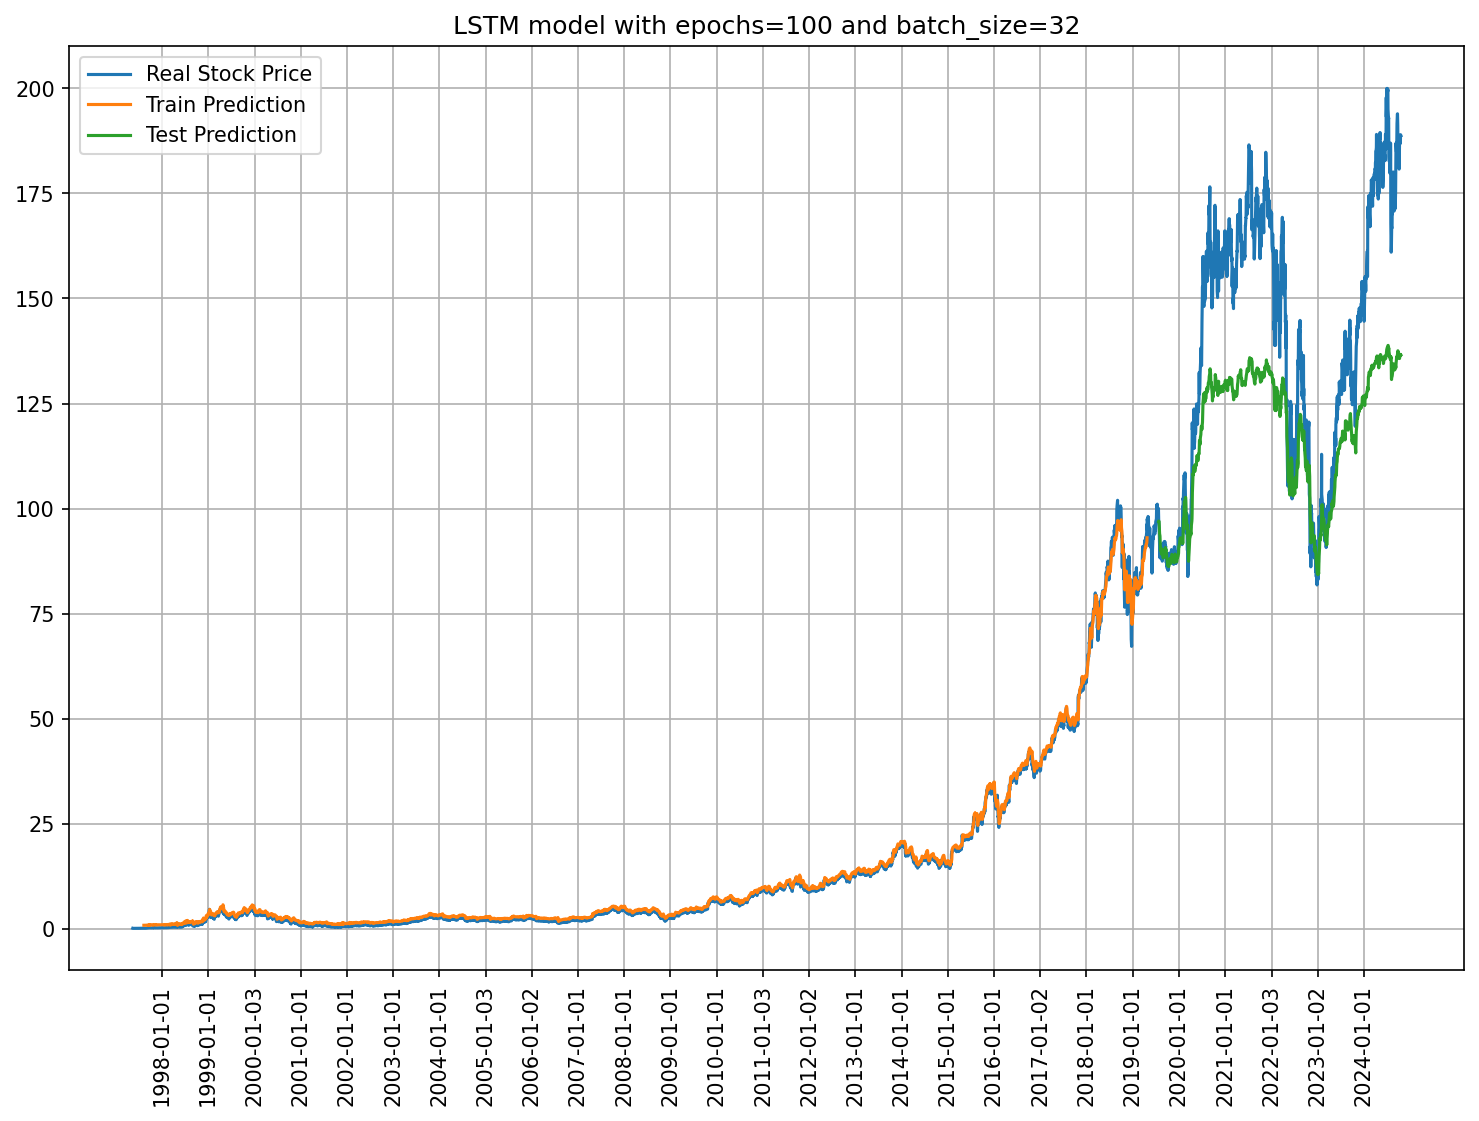

In [195]:
time_period = pd.date_range(start=pd.Timestamp(df_amzn.index[0]),
                            end=pd.Timestamp(df_amzn.index[len(df_amzn)-1]), freq='BYS')

plt.figure(figsize=(12,8),dpi=150)
plt.plot(df_amzn.index, scaler.inverse_transform(scaled_data)[:, 3], label='Real Stock Price')
plt.plot(df_amzn.index[time_step:time_step + len(train_predict)], train_predict, label='Train Prediction')
plt.plot(df_amzn.index[len(df_amzn) - len(test_predict):], test_predict, label='Test Prediction')
plt.legend()
plt.xticks(time_period, rotation = 90)
plt.title('LSTM model with epochs=100 and batch_size=32')
plt.grid(True)
plt.show()
   

#### Model 2: `epochs=20` and `batch_size=8`

In [366]:
model2 = Sequential()
model2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(units=50, return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))
model2.compile(optimizer='adam', loss='mean_squared_error')

In [368]:
model2.fit(X_train, y_train, epochs=20, batch_size=8)  

Epoch 1/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 7.9664e-04
Epoch 2/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.6921e-04
Epoch 3/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.9886e-04
Epoch 4/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.8544e-04
Epoch 5/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.7973e-04
Epoch 6/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.8177e-04
Epoch 7/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.7131e-04
Epoch 8/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.5348e-04
Epoch 9/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.5245e-04
Epoch 10/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.7602e-04
Epoch 11/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.3543e-04
Epoch 12/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.2999e-04
Epoch 13/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.5051e-04
Epoch 14/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.2925e-04
E

In [379]:
train_predict2 = model2.predict(X_train)
test_predict2 = model2.predict(X_test) 

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [381]:
train_predict2 = scaler.inverse_transform(np.concatenate((train_predict2, np.zeros((train_predict2.shape[0], scaled_data.shape[1] - 1))), axis=1))[:,0]
test_predict2 = scaler.inverse_transform(np.concatenate((test_predict2, np.zeros((test_predict2.shape[0], scaled_data.shape[1] - 1))), axis=1))[:,0]

train_rmse2 = math.sqrt(mean_squared_error(y_train, train_predict2))
print('Train rmse: {}'.format(train_rmse2))
test_rmse2 = math.sqrt(mean_squared_error(y_test, test_predict2))
print('Test rmse: {}'.format(test_rmse2))

Train rmse: 24.4702526753904
Test rmse: 121.04429211711353


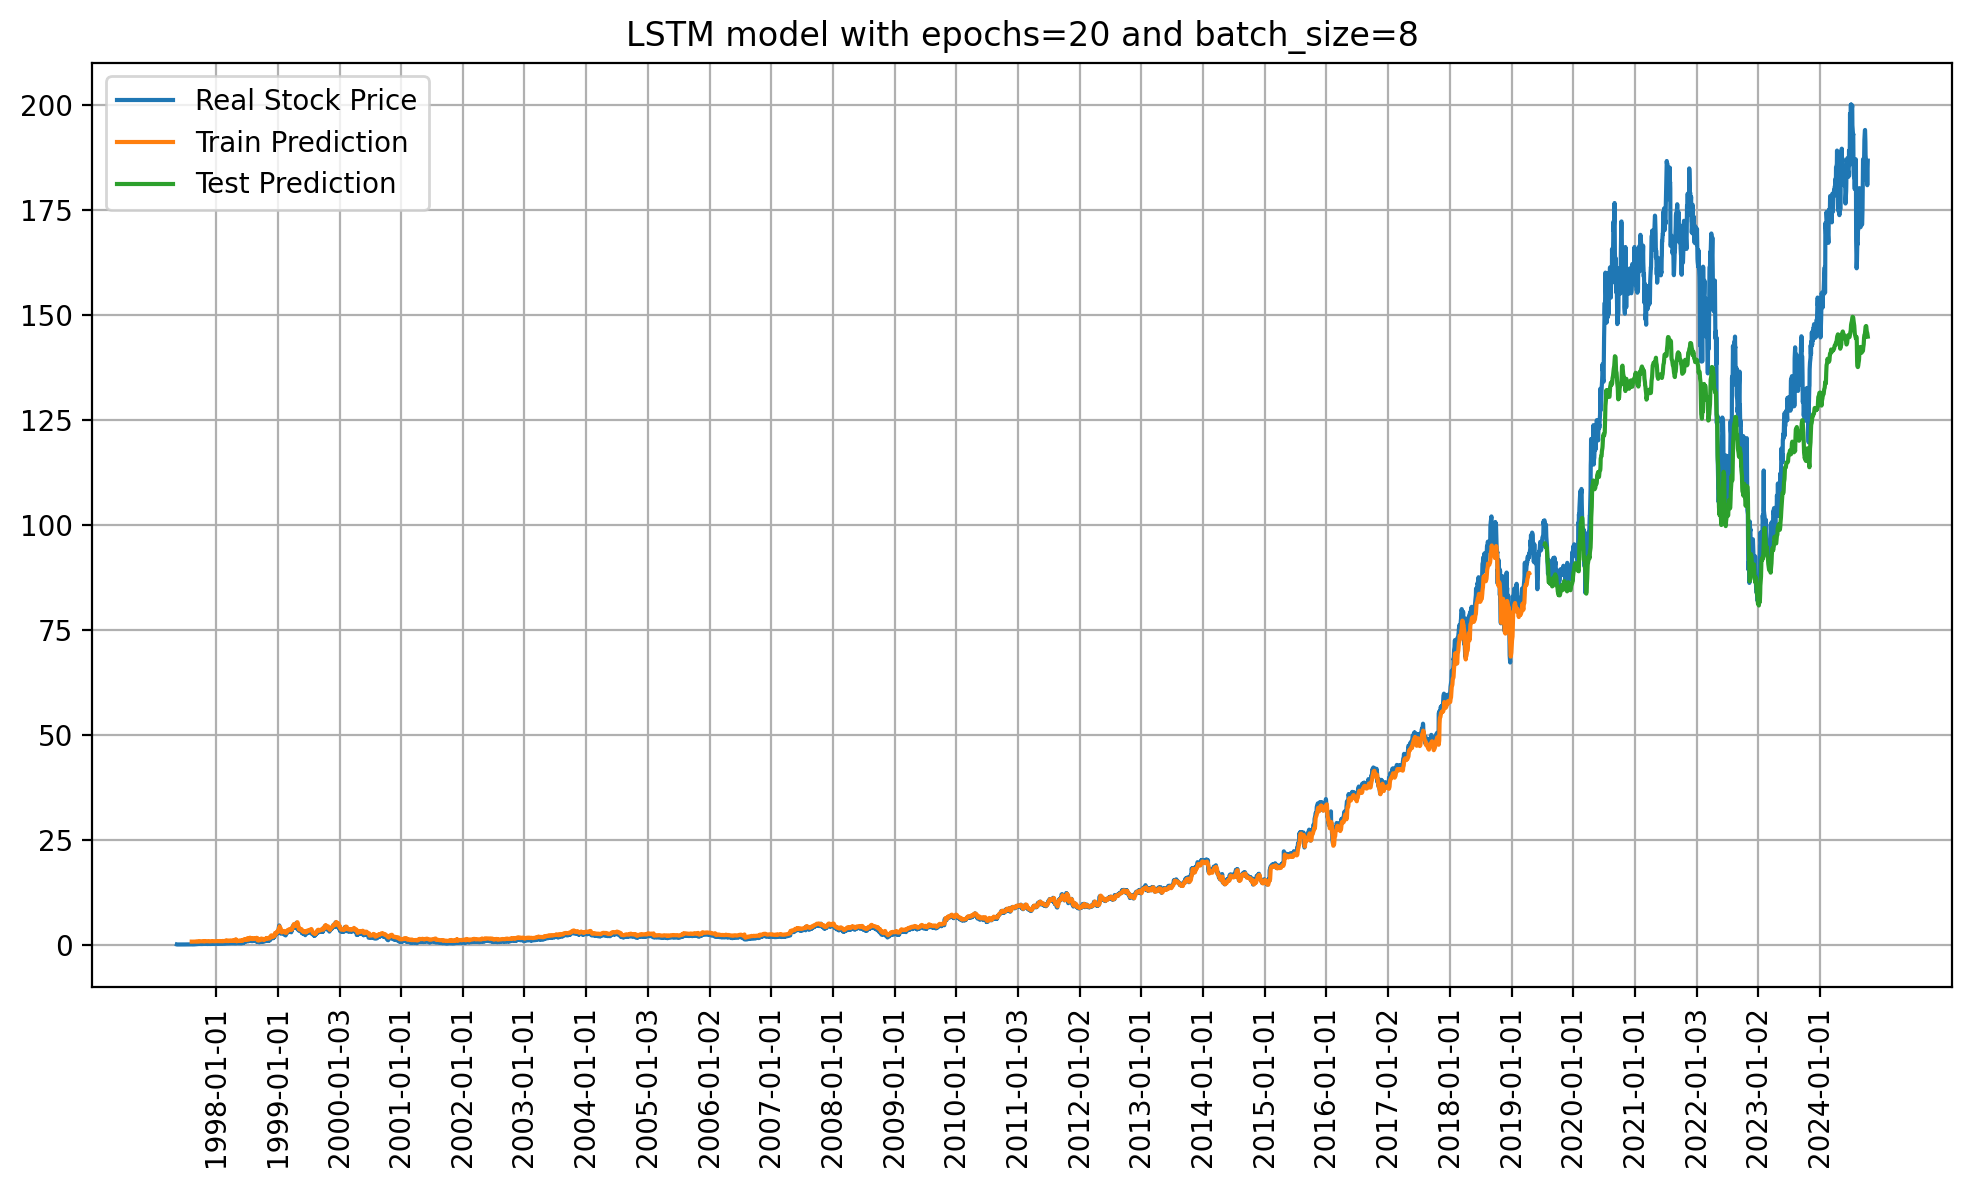

In [413]:
time_period = pd.date_range(start=pd.Timestamp(df_amzn.index[0]),
                            end=pd.Timestamp(df_amzn.index[len(df_amzn)-1]), freq='BYS')

plt.figure(figsize=(12,6),dpi=200)

plt.plot(df_amzn.index, scaler.inverse_transform(scaled_data)[:, 3],
         label='Real Stock Price')

plt.plot(df_amzn.index[time_step:time_step + len(train_predict2)],
         train_predict2, label='Train Prediction')

plt.plot(df_amzn.index[len(df_amzn) - len(test_predict2):],
         test_predict2, label='Test Prediction')

plt.grid(True)
plt.xticks(time_period, rotation = 90)
plt.title('LSTM model with epochs=20 and batch_size=8')
plt.legend()
plt.show()

#### Model 3: `epochs=50` and `batch_size=32`

In [180]:
model3 = Sequential()
model3.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model3.add(Dropout(0.2))
model3.add(LSTM(units=50, return_sequences=False))
model3.add(Dropout(0.2))
model3.add(Dense(units=1))
model3.compile(optimizer='adam', loss='mean_squared_error')

In [181]:
model3.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0018
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.2154e-04
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7048e-04
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6900e-04
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.3751e-04
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.3470e-04
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.4834e-04
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.3009e-04
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1459e-04
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.3266e-04
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.2355e-04
Epoch 12/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.1209e-04
Epoch 13/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.3828e-04
Epoch 14/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.

In [185]:
train_predict3 = model3.predict(X_train)
test_predict3 = model3.predict(X_test) 

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [186]:
import math
train_predict3 = scaler.inverse_transform(np.concatenate((train_predict3, np.zeros((train_predict3.shape[0], scaled_data.shape[1] - 1))), axis=1))[:,0]
test_predict3 = scaler.inverse_transform(np.concatenate((test_predict3, np.zeros((test_predict3.shape[0], scaled_data.shape[1] - 1))), axis=1))[:,0]

train_rmse = math.sqrt(mean_squared_error(y_train, train_predict3))
print('Train rmse: {}'.format(train_rmse))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict3))
print('Test rmse: {}'.format(test_rmse))
print('='*50)
train_mae = mean_absolute_error(y_train, train_predict3)
print('Train MAE: {}'.format(train_mae))
test_mae = mean_absolute_error(y_test, test_predict3)
print('Test MAE: {}'.format(test_mae))

Train rmse: 25.75991515398734
Test rmse: 133.0672546940282
Train MAE: 14.050900339026708
Test MAE: 130.81783542147224


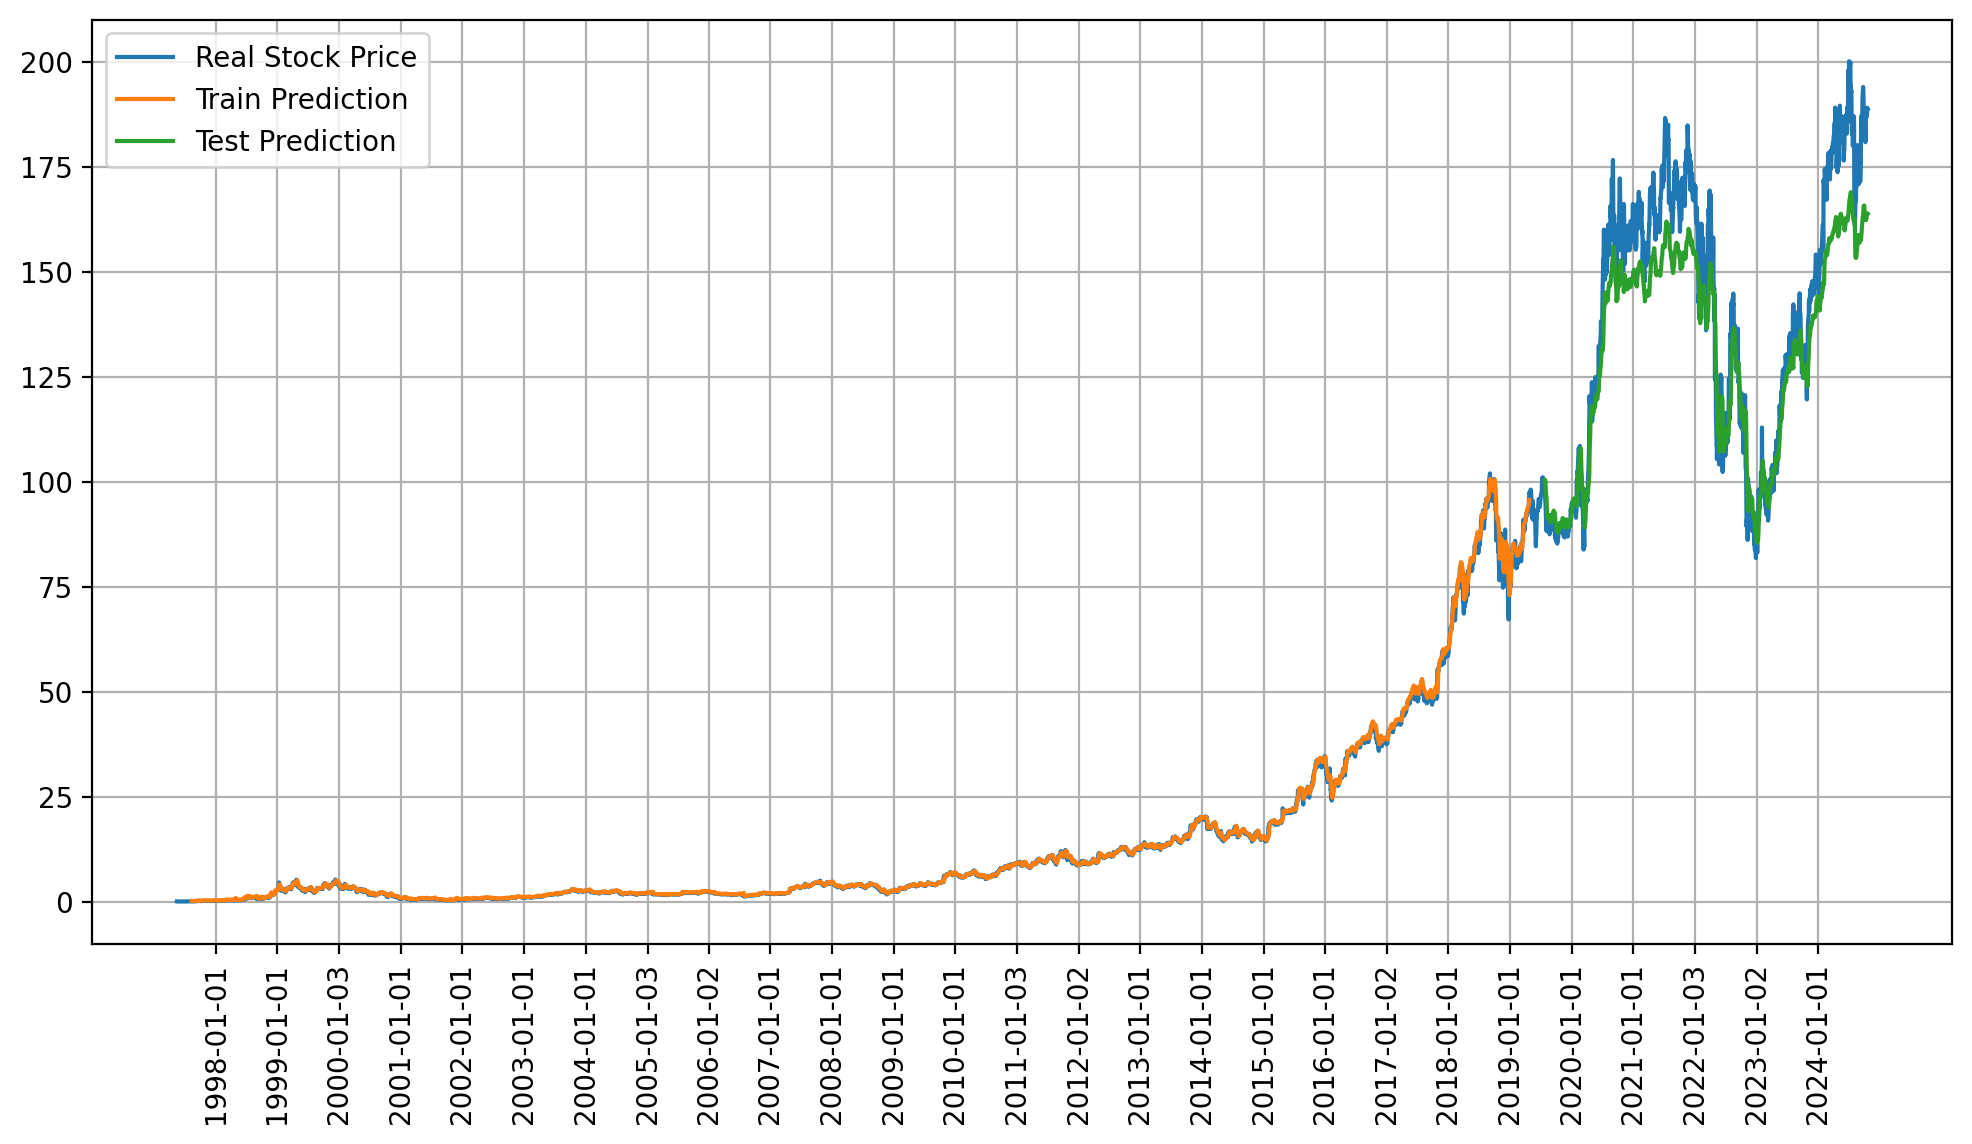

In [189]:
plt.figure(figsize=(12,6),dpi=200)

plt.plot(df_amzn.index, scaler.inverse_transform(scaled_data)[:, 3],
         label='Real Stock Price')

plt.plot(df_amzn.index[time_step:time_step + len(train_predict3)],
         train_predict3, label='Train Prediction')

plt.plot(df_amzn.index[len(df_amzn) - len(test_predict3):],
         test_predict3, label='Test Prediction')

plt.grid(True)
plt.xticks(time_period, rotation = 90)
plt.legend()
plt.show()

#### Model 4: `epochs=20` and `batch_size=64`

In [417]:
model4 = Sequential()
model4.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model4.add(Dropout(0.2))
model4.add(LSTM(units=50, return_sequences=False))
model4.add(Dropout(0.2))
model4.add(Dense(units=1))
model4.compile(optimizer='adam', loss='mean_squared_error')

In [426]:
model4.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.0010e-04
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.0204e-05
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.2157e-05
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.1706e-04
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.6184e-05
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.0525e-04
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 8.8031e-05
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.7739e-05
Epoch 9/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.0567e-04
Epoch 10/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 9.6627e-05
Epoch 11/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.0816e-04
Epoch 12/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.7448e-05
Epoch 13/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.1931e-04
Epoch 14/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 9.0912e-05
Epoch 15/20
86/

In [428]:
train_predict4 = model.predict(X_train)
test_predict4 = model.predict(X_test) 

train_predict4 = scaler.inverse_transform(np.concatenate((train_predict4, np.zeros((train_predict4.shape[0], scaled_data.shape[1] - 1))), axis=1))[:,0]
test_predict4 = scaler.inverse_transform(np.concatenate((test_predict4, np.zeros((test_predict4.shape[0], scaled_data.shape[1] - 1))), axis=1))[:,0]

train_rmse = math.sqrt(mean_squared_error(y_train, train_predict4))
print('Train rmse: {}'.format(train_rmse))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict4))
print('Test rmse: {}'.format(test_rmse))

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Train rmse: 25.034780702367538
Test rmse: 116.61111623357108


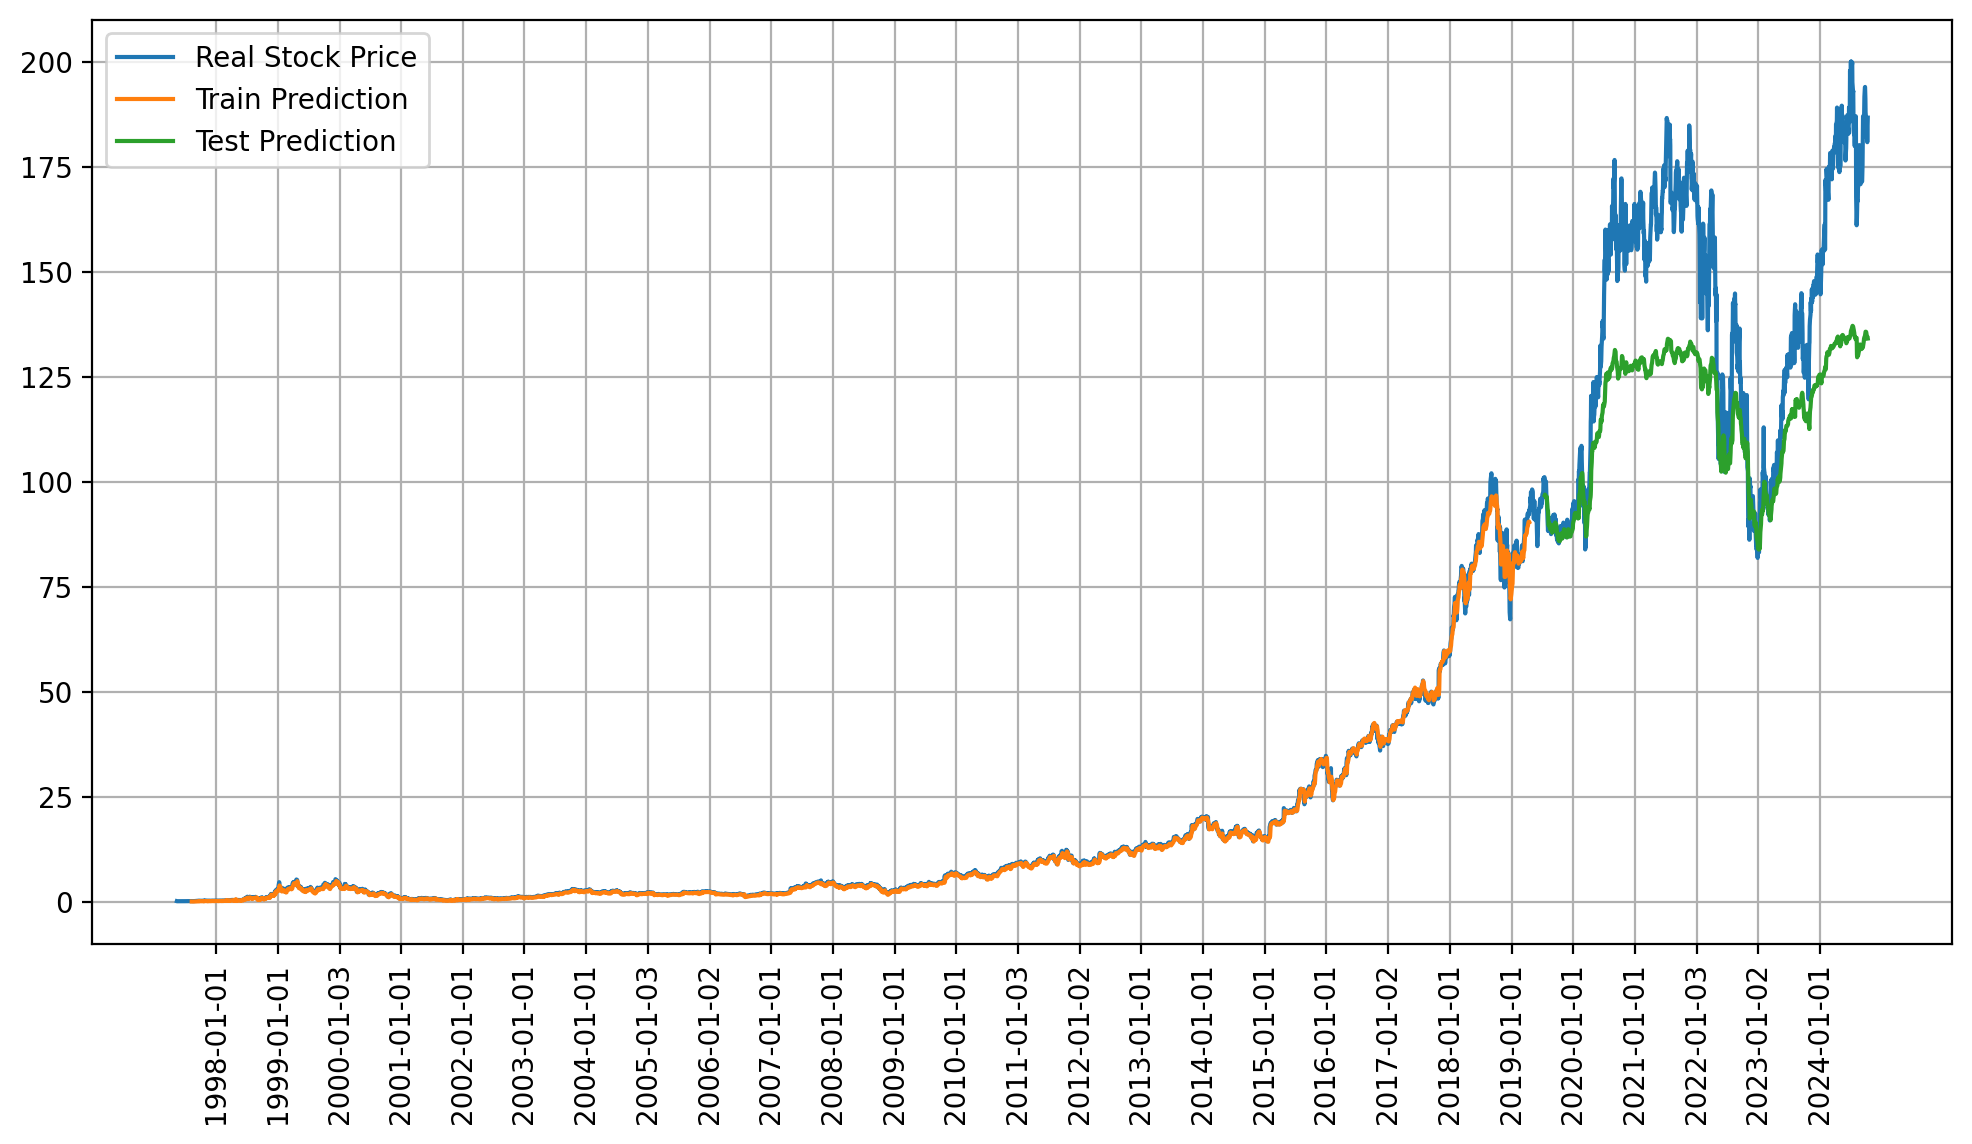

In [430]:
plt.figure(figsize=(12,6),dpi=200)

plt.plot(df_amzn.index, scaler.inverse_transform(scaled_data)[:, 3],
         label='Real Stock Price')

plt.plot(df_amzn.index[time_step:time_step + len(train_predict4)],
         train_predict4, label='Train Prediction')

plt.plot(df_amzn.index[len(df_amzn) - len(test_predict4):],
         test_predict4, label='Test Prediction')

plt.grid(True)
plt.xticks(time_period, rotation = 90)
plt.legend()
plt.show()

#### Result of LSTM models
According to the `rmse` of the models and the visualizations, the best performing LSTM model is `Model 3` with `epochs=50` and `batch_size=32`.

---
---

# Tesla Stock Price Data

### Loading Data and EDA

In [34]:
getteslainfo = yahoofinance.Ticker('TSLA')
df_tesla = pd.DataFrame(getteslainfo.history(period='max'))
df_tesla

Open        High         Low       Close  \
Date                                                                        
2010-06-29 00:00:00-04:00    1.266667    1.666667    1.169333    1.592667   
2010-06-30 00:00:00-04:00    1.719333    2.028000    1.553333    1.588667   
2010-07-01 00:00:00-04:00    1.666667    1.728000    1.351333    1.464000   
2010-07-02 00:00:00-04:00    1.533333    1.540000    1.247333    1.280000   
2010-07-06 00:00:00-04:00    1.333333    1.333333    1.055333    1.074000   
...                               ...         ...         ...         ...   
2024-10-14 00:00:00-04:00  220.130005  221.910004  213.740005  219.160004   
2024-10-15 00:00:00-04:00  220.009995  224.259995  217.119995  219.570007   
2024-10-16 00:00:00-04:00  221.399994  222.820007  218.929993  221.330002   
2024-10-17 00:00:00-04:00  221.589996  222.080002  217.899994  220.889999   
2024-10-18 00:00:00-04:00  220.710007  222.279999  219.229996  220.699997   

                              Volume  Dividends  Stock Splits  
Date                                                           
2010-06-29 00:00:00-04:00  281494500        0.0           0.0  
2010-06-30 00:00:00-04:00  257806500        0.0           0.0  
2010-07-01 00:00:00-04:00  123282000        0.0           0.0  
2010-07-02 00:00:00-04:00   77097000        0.0           0.0  
2010-07-06 00:00:00-04:00  103003500        0.0           0.0  
...                              ...        ...           ...  
2024-10-14 00:00:00-04:00   86291900        0.0           0.0  
2024-10-15 00:00:00-04:00   62988800        0.0           0.0  
2024-10-16 00:00:00-04:00   49632800        0.0           0.0  
2024-10-17 00:00:00-04:00   50791800        0.0           0.0  
2024-10-18 00:00:00-04:00   49526800        0.0           0.0  

[3602 rows x 7 columns]

In [35]:
stock_gap(df_tesla,4)

1 gaps were found by the minimum gap days of 4.


Open      High       Low     Close      Volume  \
2012-10-26 00:00:00-04:00  1.835333  1.853333  1.801333  1.825333   7161000.0   
0                               NaN       NaN       NaN       NaN         NaN   
0                               NaN       NaN       NaN       NaN         NaN   
0                               NaN       NaN       NaN       NaN         NaN   
0                               NaN       NaN       NaN       NaN         NaN   
2012-10-31 00:00:00-04:00  1.846667  1.890000  1.824667  1.875333  11628000.0   

                           Dividends  Stock Splits  
2012-10-26 00:00:00-04:00        0.0           0.0  
0                                NaN           NaN  
0                                NaN           NaN  
0                                NaN           NaN  
0                                NaN           NaN  
2012-10-31 00:00:00-04:00        0.0           0.0

There is no significant gap in the data.

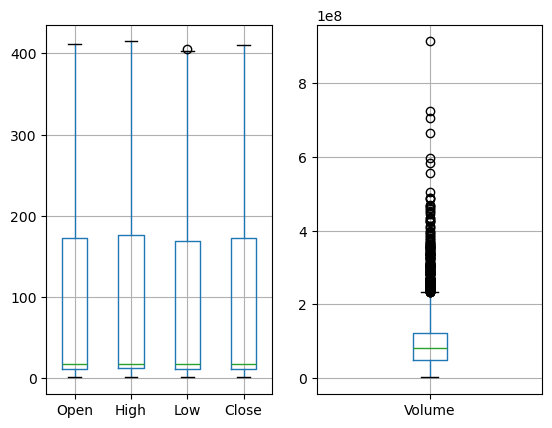

In [36]:
plt.subplot(1,2,1)
df_tesla[['Open','High','Low','Close']].boxplot()

plt.subplot(1,2,2)
df_tesla[['Volume']].boxplot()

plt.show()

<Figure size 640x480 with 0 Axes>

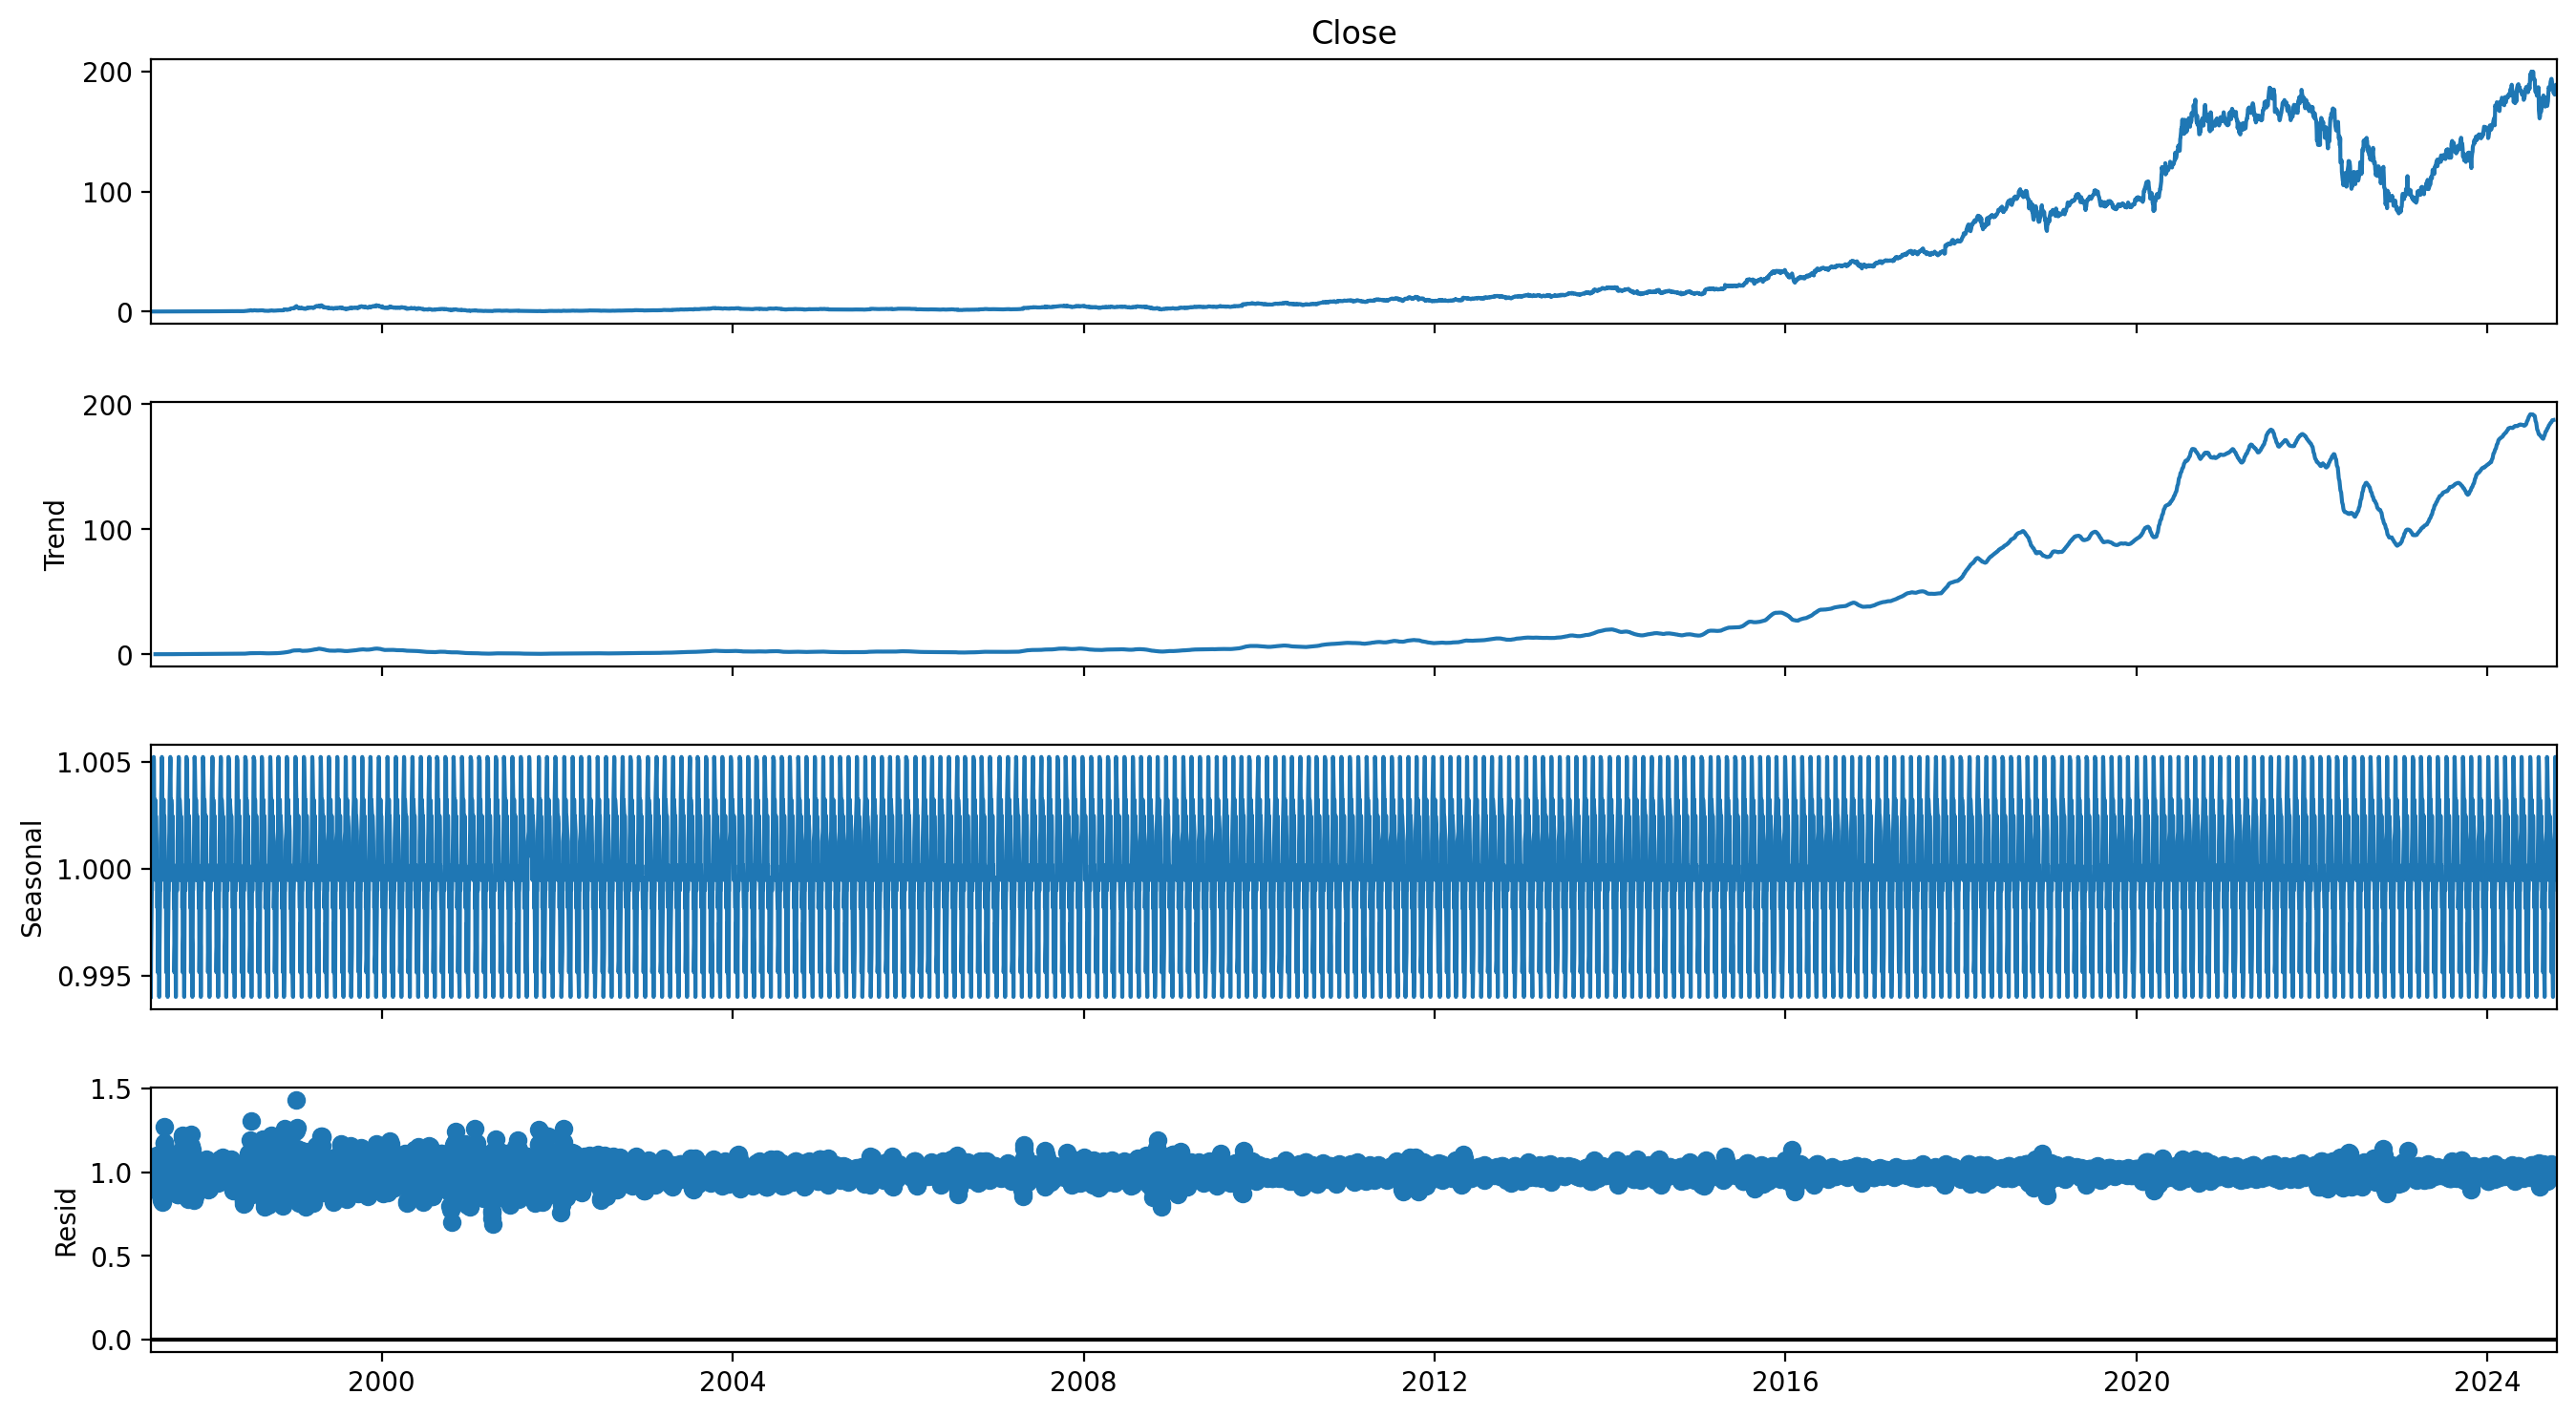

In [39]:
result_tesla = seasonal_decompose(df_tesla['Close'], model='multiplicative', period=24)
fig_tesla = plt.figure()  
fig_tesla = result.plot()  
fig_tesla.set_size_inches(15, 8)
fig_tesla.dpi = 200
fig_tesla.show()

### MLP Regression - Tesla

In [40]:
X = df_tesla[['Open','High','Low','Volume']]
Y = df_tesla['Close']


X_train_tesla, X_test_tesla, y_train_tesla, y_test_tesla = train_test_split(X,Y, test_size = 0.2,
                                                    random_state = 456, 
                                                    shuffle=False)

In [21]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

mlp_reg_tesla = MLPRegressor(hidden_layer_sizes=[50,50,50],
                       activation='relu',
                       solver='adam',
                       random_state=42)
# Scale the features
scaler_tesla = StandardScaler()
X_train_tesla = scaler_tesla.fit_transform(X_train_tesla)
X_test_tesla = scaler_tesla.transform(X_test_tesla)

mlp_reg_tesla.fit(X_train_tesla, y_train_tesla)
mlp_pred_tesls = mlp_reg_tesla.predict(X_test_tesla)

In [22]:
mlp_pred_tesla = pd.DataFrame(mlp_pred_tesls)
mlp_pred_tesla.set_index(y_test_tesla.index, inplace=True)

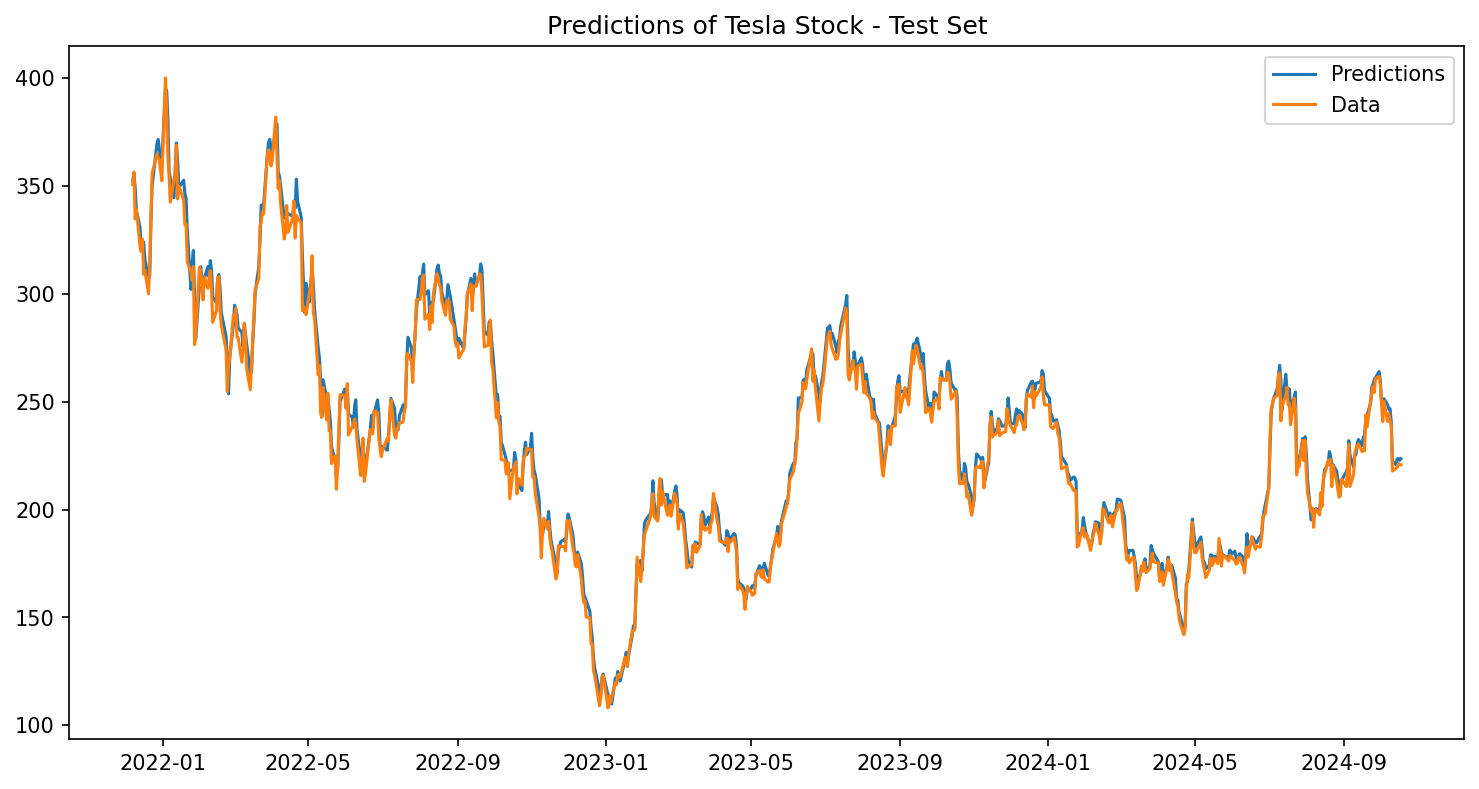

In [24]:
plt.figure(figsize=(12,6),dpi=150)
plt.plot(mlp_pred_tesla, label='Predictions')
plt.plot(y_test_tesla, label='Data')
plt.title('Predictions of Tesla Stock - Test Set')
plt.legend()
plt.show()

In [25]:
print("R-squared of the model in training set is: {}".format(mlp_reg_tesla.score(X_train_tesla, y_train_tesla)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(mlp_reg_tesla.score(X_test_tesla, y_test_tesla)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test_tesla, mlp_pred_tesls)))
print("Mean squared error of the prediction is: {}".format(mse(y_test_tesla, mlp_pred_tesls)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test_tesla, mlp_pred_tesls)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test_tesla - mlp_pred_tesls) / y_test_tesla)) * 100))

R-squared of the model in training set is: 0.999406488485739
-----Test set statistics-----
R-squared of the model in test set is: 0.9899117416727322
Mean absolute error of the prediction is: 4.176696627527587
Mean squared error of the prediction is: 29.75529724891627
Root mean squared error of the prediction is: 5.454841633715526
Mean absolute percentage error of the prediction is: 1.7974236828061578


### Time Series Analysis

In [528]:
tesla_diff = df_tesla.copy()
tesla_diff['diff1'] = df_tesla['Close'] - df_tesla['Close'].shift()

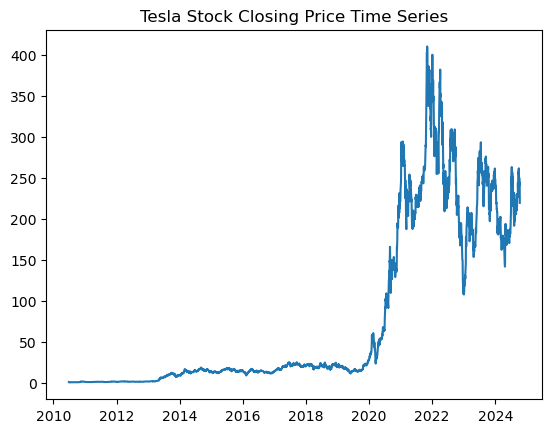

In [529]:
plt.plot(df_tesla.index, df_tesla.Close, '-', label='Close')
plt.title('Tesla Stock Closing Price Time Series')
plt.show()

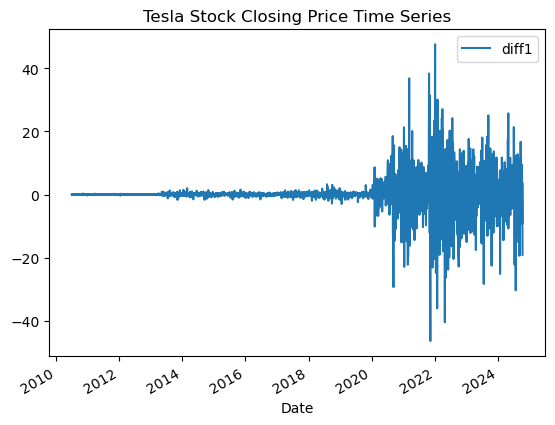

In [530]:
tesla_diff.plot(y='diff1')
plt.title('Tesla Stock Closing Price Time Series')
plt.show()

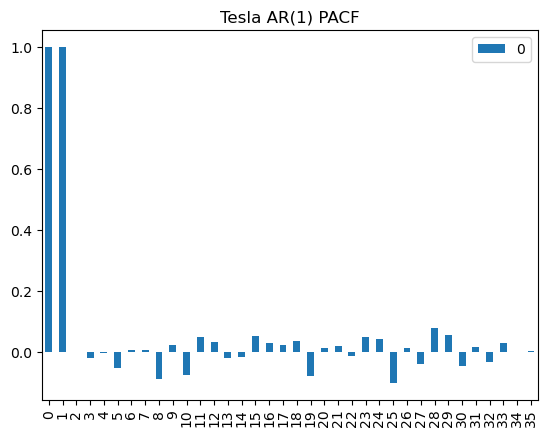

In [531]:
x_acf = pd.DataFrame(pacf(tesla_diff['Close']))
x_acf.plot(kind='bar')
plt.title('Tesla AR(1) PACF')


plt.show()

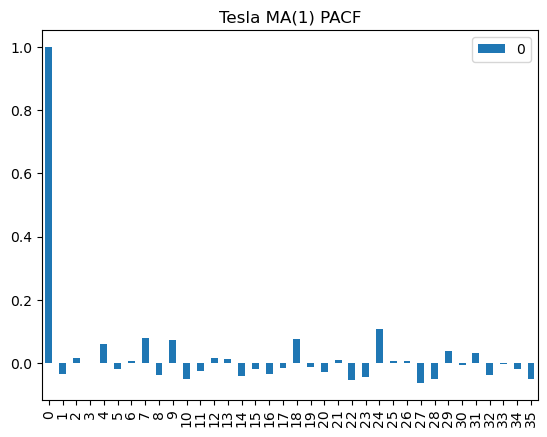

In [532]:
x_acf = pd.DataFrame(pacf(tesla_diff['diff1'][1:]))
x_acf.plot(kind='bar')
plt.title('Tesla MA(1) PACF')

plt.show()

### ARIMA model - Tesla

In [572]:
model_arima_tesla = ARIMA(df_tesla['Close'],
             order=(1,1,0))
model_fitt_tesla = model_arima_tesla.fit()
y_pred = model_fitt_tesla.forecast()
print('The MAE is: {}'.format(y_pred))

print(model_fitt_tesla.summary())
print('-'*60)
print('Residuals Description')
print(model_fitt_tesla.resid.describe())

The MAE is: 3597    220.289095
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3597
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -10781.737
Date:                Fri, 11 Oct 2024   AIC                          21567.473
Time:                        10:50:59   BIC                          21579.849
Sample:                             0   HQIC                         21571.884
                               - 3597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0337      0.009     -3.945      0.000      -0.050      -0.017
sigma2        23.5377      0.183    128.805      0.000      23.180      23.896
Ljung-

In [1237]:
start_date = pd.Timestamp(df_tesla.index[df_tesla.index.year == 2023][0])
end_date = pd.Timestamp(df_tesla.index[df_tesla.shape[0]-1])
df_slice = df_tesla.loc[start_date:end_date]

y_preds = []

for today in df_slice.index:
    model = ARIMA(df_tesla.loc[start_date:today]['Close'],
                  order=(0,1,0),
                  )
    model = model.fit()
    y_pred = model.forecast()
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index = df_slice.index)
diff_tesla = y_preds - df_tesla.loc[start_date:end_date]['Close']
diff_tesla.shape

(447,)

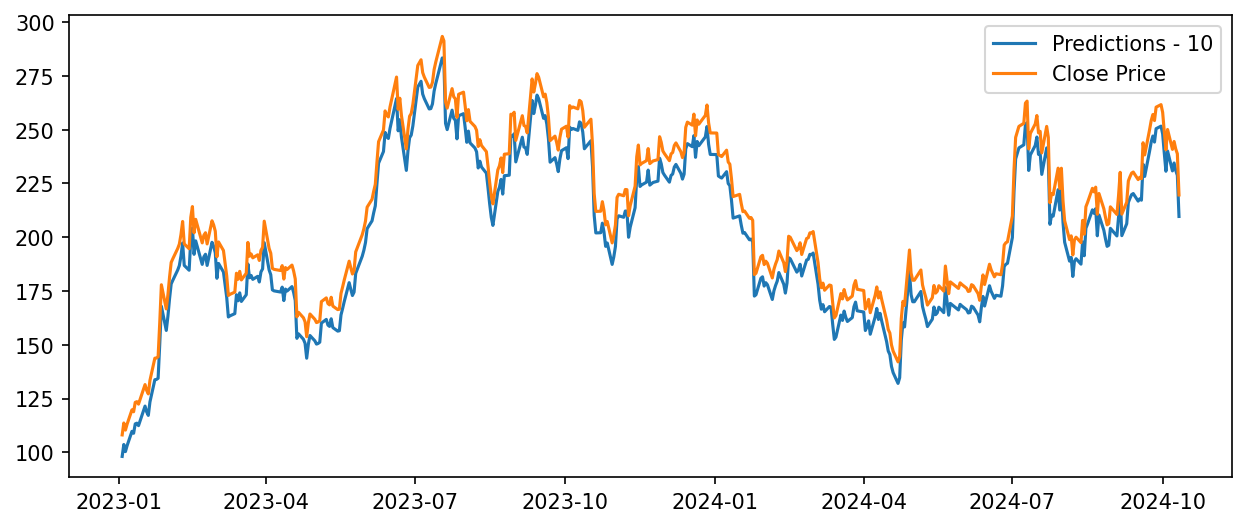

In [1239]:
plt.figure(figsize=(10,4),dpi=150)
plt.plot(y_preds-10, label='Predictions - 10')
plt.plot(df_tesla.loc[start_date:end_date]['Close'],label='Close Price')
plt.legend()
plt.show()

### LSTM Model

In [59]:
features_tsla = df_tesla[['Open','High','Low','Close','Volume']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_tsla = scaler.fit_transform(features_tsla)

In [60]:
train_size = int(len(scaled_data_tsla) * 0.8)
train_data_tsla, test_data_tsla = scaled_data_tsla[:train_size], scaled_data_tsla[train_size:]

print(train_data_tsla.shape)
print(test_data_tsla.shape)

(2881, 5)
(721, 5)


In [61]:
time_step = 60
X_train_tsla, y_train_tsla = create_dataset(train_data_tsla, time_step)
X_test_tsla, y_test_tsla = create_dataset(test_data_tsla, time_step)

print(X_train_tsla.shape)
print(y_train_tsla.shape)

(2820, 60, 5)
(2820,)


In [62]:
X_train_tsla = X_train_tsla.reshape(X_train_tsla.shape[0], X_train_tsla.shape[1],
                                    X_train_tsla.shape[2])
X_test_tsla = X_test_tsla.reshape(X_test_tsla.shape[0], X_test_tsla.shape[1],
                                  X_test_tsla.shape[2])

print(X_train_tsla.shape)
print(X_test_tsla.shape)

(2820, 60, 5)
(660, 60, 5)


#### Model 1: `epochs=50` and `batch_size=32`

In [675]:
model1_tsla = Sequential()
model1_tsla.add(LSTM(units=50, return_sequences=True, 
                     input_shape=(X_train_tsla.shape[1], X_train_tsla.shape[2])))
model1_tsla.add(Dropout(0.2))
model1_tsla.add(LSTM(units=50, return_sequences=False))
model1_tsla.add(Dropout(0.2))
model1_tsla.add(Dense(units=1))
model1_tsla.compile(optimizer='adam', loss='mean_squared_error')
model1_tsla.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [655]:
model1_tsla.fit(X_train_tsla, y_train_tsla, epochs=50, batch_size=32)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0081
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.7162e-04
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.1701e-04
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0163e-04
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.6628e-04
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.9801e-04
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.2631e-04
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.5736e-04
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7088e-04
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7985e-04
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6113e-04
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6257e-04
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3706e-04
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1760e-04
Epoch 15/50
88/88 ━

In [663]:
train_predict1_tsla = model1_tsla.predict(X_train_tsla)
test_predict1_tsla = model1_tsla.predict(X_test_tsla) 

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [56]:
train_predict1_tsla = scaler.inverse_transform(np.concatenate((train_predict1_tsla,
                                                               np.zeros((train_predict1_tsla.shape[0],
                                                                         scaled_data_tsla.shape[1] - 1))),
                                                              axis=1))[:,0]
test_predict1_tsla = scaler.inverse_transform(np.concatenate((test_predict1_tsla,
                                                              np.zeros((test_predict1_tsla.shape[0],
                                                                        scaled_data_tsla.shape[1] - 1))),
                                                             axis=1))[:,0]

train_rmse_tsla = math.sqrt(mean_squared_error(y_train_tsla, train_predict1_tsla))
print('Train rmse: {}'.format(train_rmse_tsla))
test_rmse_tsla = math.sqrt(mean_squared_error(y_test_tsla, test_predict1_tsla))
print('Test rmse: {}'.format(test_rmse_tsla))

NameError: name 'train_predict1_tsla' is not defined

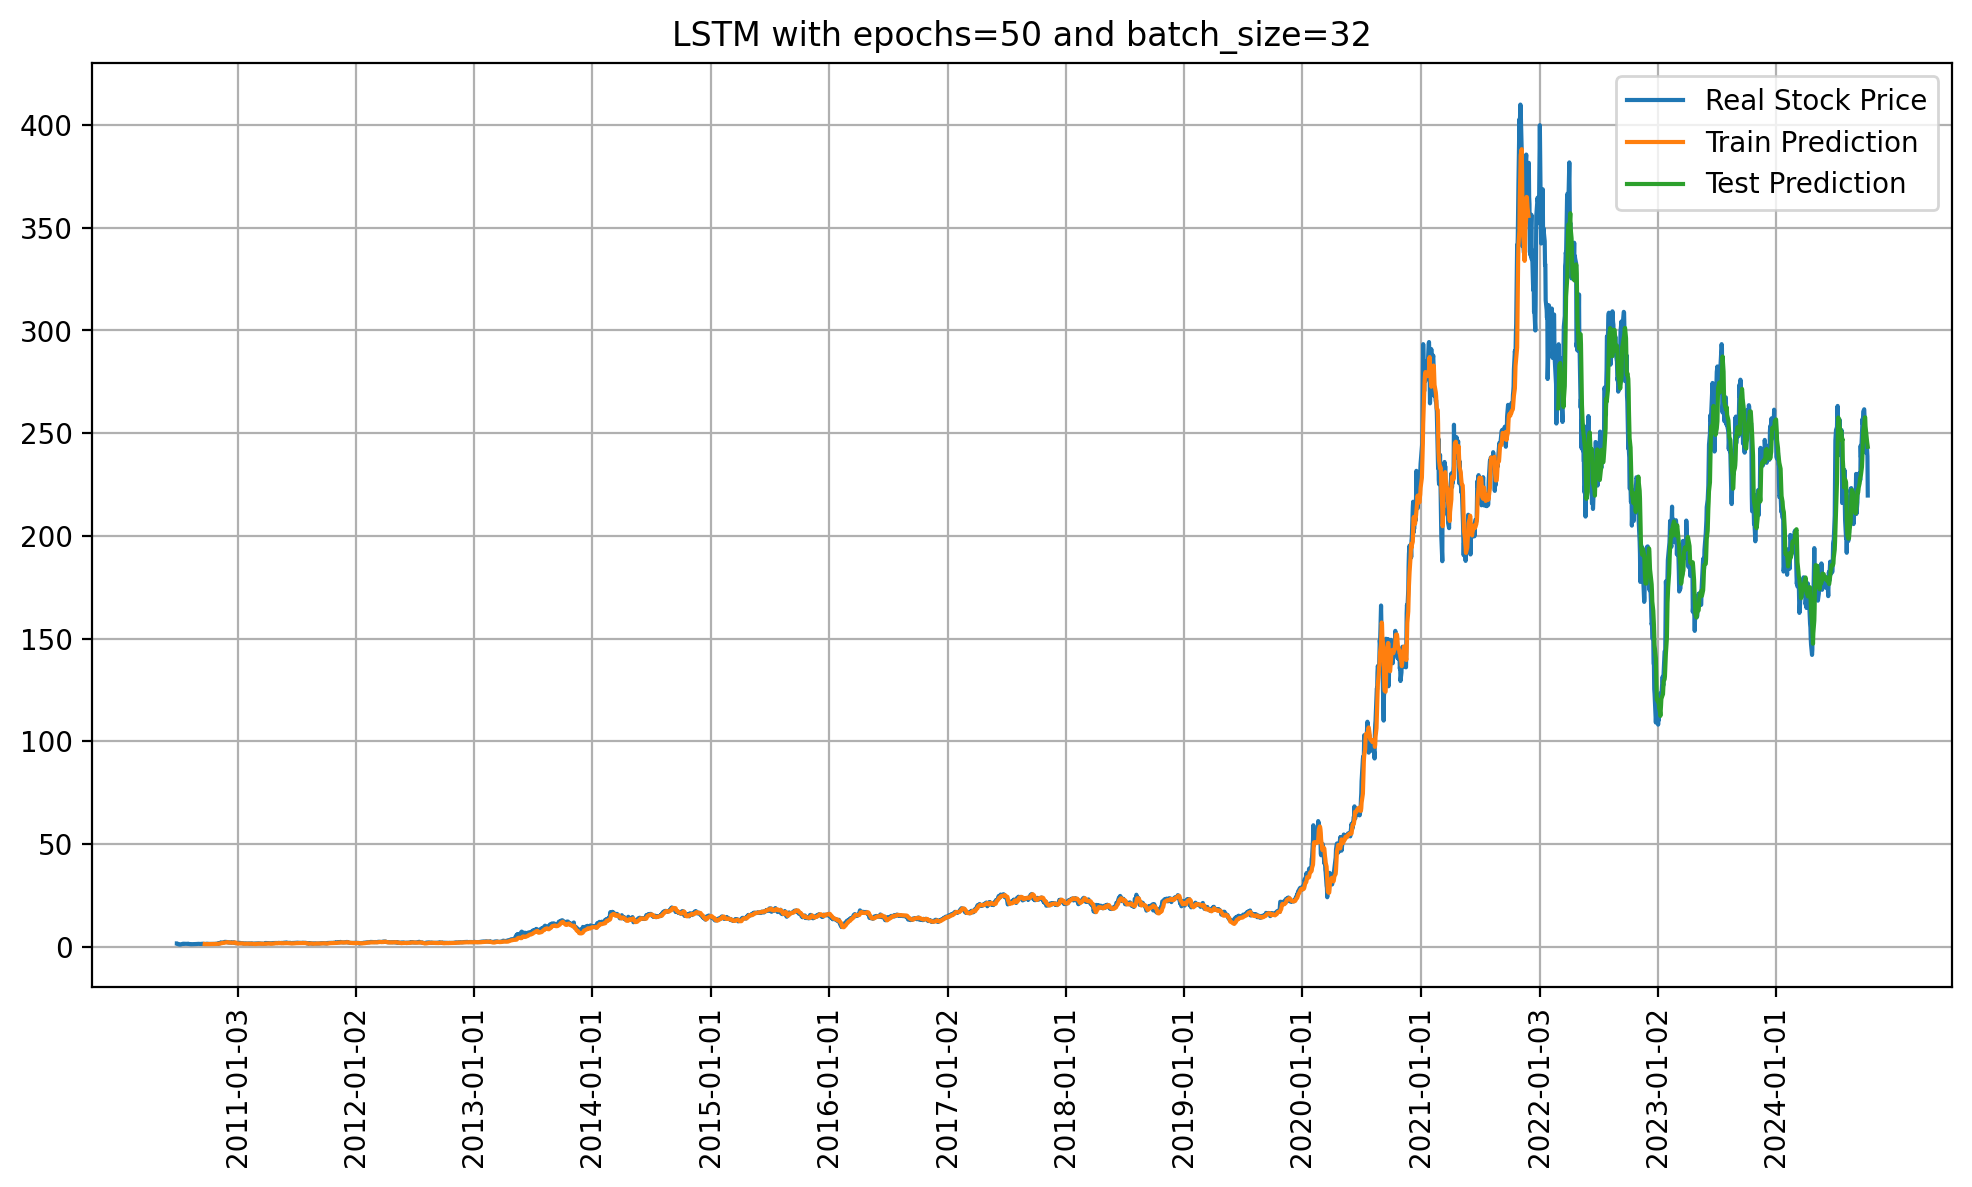

In [697]:
time_period_tsla = pd.date_range(start=pd.Timestamp(df_tesla.index[0]),
                            end=pd.Timestamp(df_tesla.index[len(df_tesla)-1]), freq='BYS')

plt.figure(figsize=(12,6),dpi=200)

plt.plot(df_tesla.index, scaler.inverse_transform(scaled_data_tsla)[:, 3],
         label='Real Stock Price')

plt.plot(df_tesla.index[time_step:time_step + len(train_predict1_tsla)],
         train_predict1_tsla, label='Train Prediction')

plt.plot(df_tesla.index[len(df_tesla) - len(test_predict1_tsla):],
         test_predict1_tsla, label='Test Prediction')

plt.grid(True)
plt.xticks(time_period_tsla, rotation = 90)
plt.title('LSTM with epochs=50 and batch_size=32')
plt.legend()
plt.show()

#### Model 2: `epochs=50` and `batch_size=8`

In [693]:
model2_tsla = Sequential()
model2_tsla.add(LSTM(units=50, return_sequences=True, 
                     input_shape=(X_train_tsla.shape[1], X_train_tsla.shape[2])))
model2_tsla.add(Dropout(0.2))
model2_tsla.add(LSTM(units=50, return_sequences=False))
model2_tsla.add(Dropout(0.2))
model2_tsla.add(Dense(units=1))
model2_tsla.compile(optimizer='adam', loss='mean_squared_error')
model2_tsla.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [695]:
model2_tsla.fit(X_train_tsla, y_train_tsla, epochs=50, batch_size=8)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0031
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.4776e-04
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.4638e-04
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.2057e-04
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.5781e-04
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.6501e-04
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.3208e-04
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.3356e-04
Epoch 10/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.4410e-04
Epoch 11/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.8656e-04
Epoch 12/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.1653e-04
Epoch 13/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.6427e-04
Epoch 14/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.6566e-04
Epoch 15/

In [699]:
train_predict2_tsla = model2_tsla.predict(X_train_tsla)
test_predict2_tsla = model2_tsla.predict(X_test_tsla) 

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [701]:
train_predict2_tsla = scaler.inverse_transform(np.concatenate((train_predict2_tsla,
                                                               np.zeros((train_predict2_tsla.shape[0],
                                                                         scaled_data_tsla.shape[1] - 1))),
                                                              axis=1))[:,0]
test_predict2_tsla = scaler.inverse_transform(np.concatenate((test_predict2_tsla,
                                                              np.zeros((test_predict2_tsla.shape[0],
                                                                        scaled_data_tsla.shape[1] - 1))),
                                                             axis=1))[:,0]

train_rmse_tsla = math.sqrt(mean_squared_error(y_train_tsla, train_predict2_tsla))
print('Train rmse: {}'.format(train_rmse_tsla))
test_rmse_tsla = math.sqrt(mean_squared_error(y_test_tsla, test_predict2_tsla))
print('Test rmse: {}'.format(test_rmse_tsla))

Train rmse: 80.01238976647151
Test rmse: 226.35774146426297


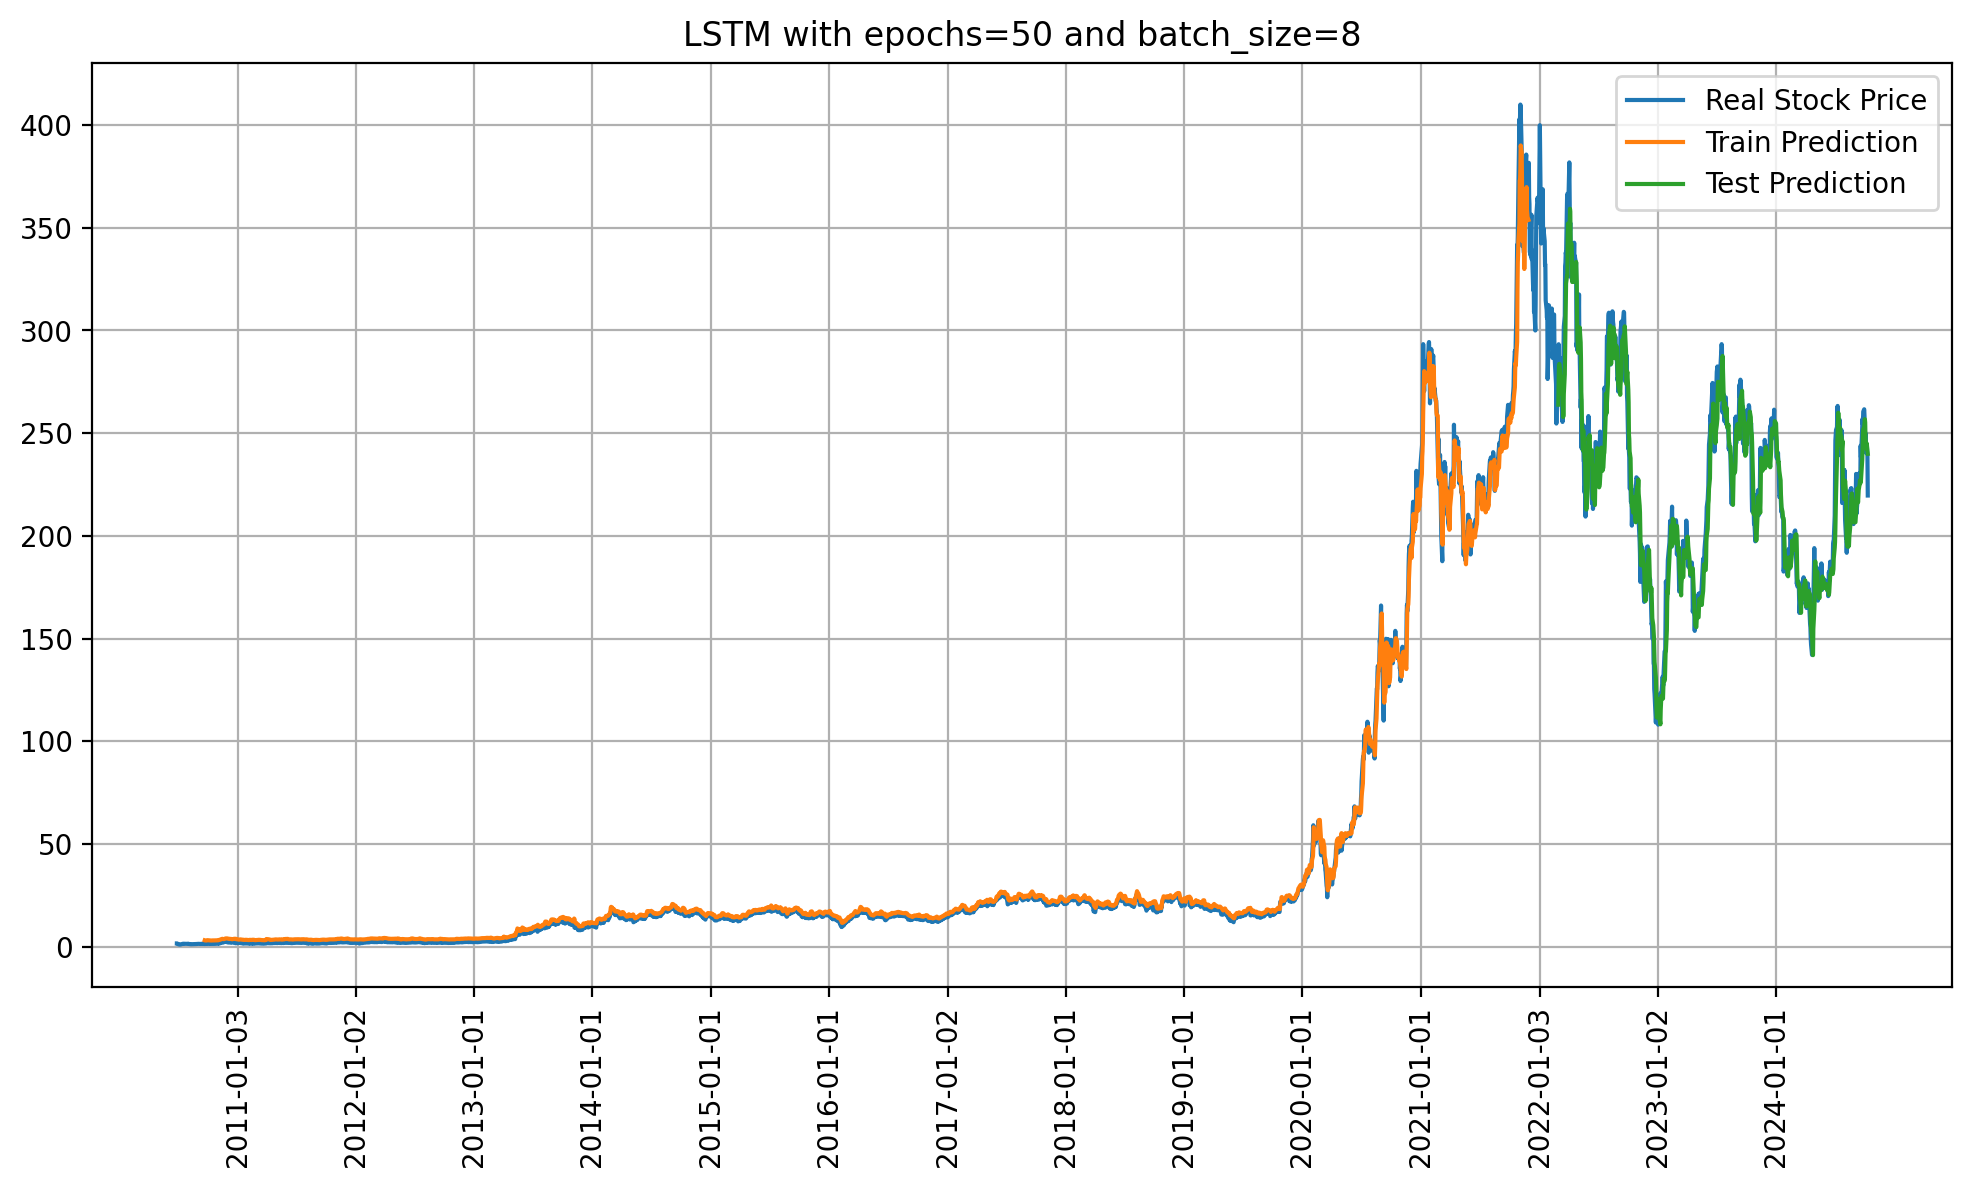

In [703]:
time_period_tsla = pd.date_range(start=pd.Timestamp(df_tesla.index[0]),
                            end=pd.Timestamp(df_tesla.index[len(df_tesla)-1]), freq='BYS')

plt.figure(figsize=(12,6),dpi=200)

plt.plot(df_tesla.index, scaler.inverse_transform(scaled_data_tsla)[:, 3],
         label='Real Stock Price')

plt.plot(df_tesla.index[time_step:time_step + len(train_predict2_tsla)],
         train_predict2_tsla, label='Train Prediction')

plt.plot(df_tesla.index[len(df_tesla) - len(test_predict2_tsla):],
         test_predict2_tsla, label='Test Prediction')

plt.grid(True)
plt.xticks(time_period_tsla, rotation = 90)
plt.title('LSTM with epochs=50 and batch_size=8')
plt.legend()
plt.show()

Comparing results of model1 and model2, show that the model with `epochs=50` and  `batch_size=32` performs better.

#### Model 3

In [52]:
model3_tsla = Sequential()
model3_tsla.add(LSTM(units=50, return_sequences=True, 
                     input_shape=(X_train_tsla.shape[1], X_train_tsla.shape[2])))
model3_tsla.add(Dropout(0.2))
model3_tsla.add(Dense(units=1))
model3_tsla.compile(optimizer='adam', loss='mean_squared_error')
model3_tsla.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60, 1)          │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model3_tsla.fit(X_train_tsla, y_train_tsla, epochs=50, batch_size=8)

Epoch 1/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0294
Epoch 2/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0335
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0292
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0322
Epoch 5/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0337
Epoch 6/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0312
Epoch 7/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0335
Epoch 8/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0285
Epoch 9/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0308
Epoch 10/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0282
Epoch 11/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0305
Epoch 12/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0333
Epoch 13/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0333
Epoch 14/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0296
Epoch 15/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

In [63]:
train_predict3_tsla = model3_tsla.predict(X_train_tsla)
test_predict3_tsla = model3_tsla.predict(X_test_tsla) 

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [64]:
train_predict3_tsla = scaler.inverse_transform(np.concatenate((train_predict3_tsla,
                                                               np.zeros((train_predict3_tsla.shape[0],
                                                                         scaled_data_tsla.shape[1] - 1))),
                                                              axis=1))[:,0]
test_predict3_tsla = scaler.inverse_transform(np.concatenate((test_predict3_tsla,
                                                              np.zeros((test_predict3_tsla.shape[0],
                                                                        scaled_data_tsla.shape[1] - 1))),
                                                             axis=1))[:,0]

train_rmse_tsla = math.sqrt(mean_squared_error(y_train_tsla, train_predict3_tsla))
print('Train rmse: {}'.format(train_rmse_tsla))
test_rmse_tsla = math.sqrt(mean_squared_error(y_test_tsla, test_predict3_tsla))
print('Test rmse: {}'.format(test_rmse_tsla))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)